# ThreathDetection using BERT
multi-label classification, which is has many feature in dependent variable.

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# from datasets import load_dataset

from google.colab import data_table

data_table.disable_dataframe_formatter()
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import cross_val_score, KFold

import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
DataPath = "/content/drive/MyDrive/Magang/ThreatDetection/Data/"

In [ ]:
df = pd.read_csv(f"{DataPath}concanate.csv")

In [ ]:
df.drop(columns = 'Unnamed: 0', inplace= True)

In [ ]:
df

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
0,- disaat semua cowok berusaha melacak perhatia...,1,1,0,0,0,0,0,1,0,0,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,1,0,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13596,Semua orang kacau karena hal aneh ini karena k...,0,0,1,0,0,0,1,0,1,0,0,0
13597,Sebenarnya orang-orang aneh ini sangat kuat me...,0,1,0,0,0,0,0,0,0,1,0,0
13598,Aku juga seorang pendeta arab seperti ini kede...,0,0,1,1,0,0,0,0,0,0,0,0
13599,Jadi kau bercinta dengan saudaramu bukan denga...,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
df = df.sample(frac= 1, random_state= 42)
df.head()

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
8715,USER Sibuk ngewe',1,0,0,0,0,0,0,0,0,0,0,0
12763,"Simak :; ; Kira kira Dampaknya sama gak ya, an...",0,1,0,0,0,0,0,1,0,0,0,0
4881,USER USER Jaman SBY yg demo PDIP,0,0,1,0,0,0,0,1,0,0,0,0
102,USER USER Yg goblog itu adalah bani cebong tuk...,1,0,1,0,0,0,0,1,0,0,0,0
6032,memek becek terus.',1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X, Y = df.iloc[:, :1].values, df.iloc[:, 1:].values
X, Y= np.squeeze(X), np.squeeze(Y)


In [ ]:
len(X), len(Y)

(13601, 13601)

In [ ]:
np.shape(X), np.shape(Y)

((13601,), (13601, 12))

In [ ]:
X, Y = X.tolist(), Y.tolist()

## Using Bert Transformers to tokenize

In [ ]:


model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)



Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# encode text
X_encode_input= tokenizer(X, padding= True, truncation=True, max_length=512, return_tensors="tf")

In [ ]:
X_encode_input

{'input_ids': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[    3, 18992, 12229, ...,     2,     2,     2],
       [    3, 17886,  1028, ...,     2,     2,     2],
       [    3, 18992, 18992, ...,     2,     2,     2],
       ...,
       [    3,    40, 25392, ...,     2,     2,     2],
       [    3,     7, 16831, ...,     2,     2,     2],
       [    3, 18821,  1538, ...,     2,     2,     2]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
X_encode_input['input_ids'][0]

<tf.Tensor: shape=(390,), dtype=int32, numpy=
array([    3, 18992, 12229, 29965,  5789,     0,     1,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,   

In [ ]:
Y_tensor = tf.constant(Y)

In [ ]:
Y_tensor.shape

TensorShape([13601, 12])

In [ ]:
X_encode_input

{'input_ids': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[    3, 18992, 12229, ...,     2,     2,     2],
       [    3, 17886,  1028, ...,     2,     2,     2],
       [    3, 18992, 18992, ...,     2,     2,     2],
       ...,
       [    3,    40, 25392, ...,     2,     2,     2],
       [    3,     7, 16831, ...,     2,     2,     2],
       [    3, 18821,  1538, ...,     2,     2,     2]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13601, 390), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
X_encode_input['input_ids'].shape

TensorShape([13601, 390])

In [ ]:
n_classes = len(Y_tensor[0])

## Split Dataset

In [ ]:
X_train, X_test = X_encode_input['input_ids'][:13000], X_encode_input['input_ids'][13000:]

In [ ]:
Y_train, Y_test = Y_tensor[:13000], Y_tensor[13000:]

In [ ]:
len(X_train), len(X_test)

(13000, 601)

In [ ]:
len(Y_train), len(Y_test)

(13000, 601)

#### Gambaran encode Embedding

In [ ]:
idx = 30
X[idx], Y[idx]

('"Sosialisasi Keamanan Pangan"* - ISWI @ Aula Gedung BPOM Jl. Percetakan Negara, 18042018',
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
tokenize = tokenizer.tokenize(X[idx])
print(tokenize)
ID = tokenizer.convert_tokens_to_ids(tokenize)
print(ID)
decode_string = tokenizer.decode(ID)
print(decode_string)

['"', 'sosialisasi', 'keamanan', 'pangan', '"', '*', '-', 'is', '##wi', '@', 'aula', 'gedung', 'bp', '##om', 'jl', '.', 'percetakan', 'negara', ',', '1804', '##20', '##18']
[6, 22213, 4275, 7316, 6, 13, 16, 1744, 3992, 33, 12809, 3573, 6500, 1562, 6318, 17, 13749, 1844, 15, 24994, 3904, 7100]
" sosialisasi keamanan pangan " * - iswi @ aula gedung bpom jl. percetakan negara, 18042018


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices(encode_input['input_ids'], Y_train).batch(2)

In [ ]:
X_train

<tf.Tensor: shape=(13000, 390), dtype=int32, numpy=
array([[    3, 18992, 12229, ...,     2,     2,     2],
       [    3, 17886,  1028, ...,     2,     2,     2],
       [    3, 18992, 18992, ...,     2,     2,     2],
       ...,
       [    3, 18992,  4538, ...,     2,     2,     2],
       [    3, 16143,  6908, ...,     2,     2,     2],
       [    3, 18992, 19344, ...,     2,     2,     2]], dtype=int32)>

In [ ]:
tokenize = tokenizer.tokenize("Raja dan lelaki")
print(tokenize)
ID = tokenizer.convert_tokens_to_ids(tokenize)
print(ID)
decode_string = tokenizer.decode(ID)
print(decode_string)
token = tokenizer.convert_ids_to_tokens([2165])
print()

['raja', 'dan', 'lelaki']
[2167, 1509, 6969]
raja dan lelaki
['user']


## Build Model

In [ ]:
n_classes

12

#### optimizer experiment

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "relu", name= "hidden_Layer1"),
    tf.keras.layers.Dense(50, activation= "relu", name= "hidden_Layer2"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_1.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 3ms/step - loss: 35.9549 - binary_crossentropy: 35.9549 - binary_accuracy: 0.8520
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 0.5866 - binary_crossentropy: 0.5866 - binary_accuracy: 0.8927
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 0.4576 - binary_crossentropy: 0.4576 - binary_accuracy: 0.8936
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3889 - binary_crossentropy: 0.3889 - binary_accuracy: 0.8938
Epoch 5/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3526 - binary_crossentropy: 0.3526 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3338 - binary_crossentropy: 0.3338 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 1s 2ms/step - loss: 0.3181 - binary_crossentropy: 0.3181 - binary_accuracy: 0.8939
Epoch 8/10
407/407 [===================

In [ ]:
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12)                4692      
                                                                 
Total params: 4692 (18.33 KB)
Trainable params: 4692 (18.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "relu", name= "hidden_Layer1"),
    tf.keras.layers.Dense(50, activation= "relu", name= "hidden_Layer2"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_2.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.AdamW(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_2.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 3ms/step - loss: 31.8122 - binary_crossentropy: 31.8122 - binary_accuracy: 0.8292
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 2.4839 - binary_crossentropy: 2.4839 - binary_accuracy: 0.8406
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 1.0723 - binary_crossentropy: 1.0723 - binary_accuracy: 0.8511
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.6565 - binary_crossentropy: 0.6565 - binary_accuracy: 0.8608
Epoch 5/10
407/407 [==============================] - 2s 4ms/step - loss: 0.4983 - binary_crossentropy: 0.4983 - binary_accuracy: 0.8675
Epoch 6/10
407/407 [==============================] - 2s 5ms/step - loss: 0.4063 - binary_crossentropy: 0.4063 - binary_accuracy: 0.8734
Epoch 7/10
407/407 [==============================] - 2s 5ms/step - loss: 0.3871 - binary_crossentropy: 0.3871 - binary_accuracy: 0.8757
Epoch 8/10
407/407 [===================

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "relu", name= "hidden_Layer1"),
    tf.keras.layers.Dense(50, activation= "relu", name= "hidden_Layer2"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_3.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adamax(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_3.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 3ms/step - loss: 77.2198 - binary_crossentropy: 77.2198 - binary_accuracy: 0.8374
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 23.5583 - binary_crossentropy: 23.5583 - binary_accuracy: 0.8442
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 8.1612 - binary_crossentropy: 8.1612 - binary_accuracy: 0.8251
Epoch 4/10
407/407 [==============================] - 2s 4ms/step - loss: 1.1430 - binary_crossentropy: 1.1430 - binary_accuracy: 0.8828
Epoch 5/10
407/407 [==============================] - 2s 4ms/step - loss: 0.6280 - binary_crossentropy: 0.6280 - binary_accuracy: 0.8921
Epoch 6/10
407/407 [==============================] - 2s 4ms/step - loss: 0.4857 - binary_crossentropy: 0.4857 - binary_accuracy: 0.8931
Epoch 7/10
407/407 [==============================] - 2s 5ms/step - loss: 0.4011 - binary_crossentropy: 0.4011 - binary_accuracy: 0.8935
Epoch 8/10
407/407 [=================

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "relu", name= "hidden_Layer1"),
    tf.keras.layers.Dense(50, activation= "relu", name= "hidden_Layer2"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_3.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.SGD(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_3.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 4ms/step - loss: 55990.2969 - binary_crossentropy: 55990.2969 - binary_accuracy: 0.8491
Epoch 2/10
407/407 [==============================] - 1s 4ms/step - loss: 0.4263 - binary_crossentropy: 0.4263 - binary_accuracy: 0.8564
Epoch 3/10
407/407 [==============================] - 1s 4ms/step - loss: 0.3980 - binary_crossentropy: 0.3980 - binary_accuracy: 0.8564
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3767 - binary_crossentropy: 0.3767 - binary_accuracy: 0.8564
Epoch 5/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3592 - binary_crossentropy: 0.3592 - binary_accuracy: 0.8869
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3446 - binary_crossentropy: 0.3446 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3323 - binary_crossentropy: 0.3323 - binary_accuracy: 0.8939
Epoch 8/10
407/407 [=============

Use Adam Optimazer

#### layer experiment

In [ ]:
model_4_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "relu", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "relu", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "relu", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_4_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_4_1.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 6s 4ms/step - loss: 15.5276 - binary_crossentropy: 15.5276 - binary_accuracy: 0.8610
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.5097 - binary_crossentropy: 0.5097 - binary_accuracy: 0.8939
Epoch 3/10
407/407 [==============================] - 2s 4ms/step - loss: 0.4346 - binary_crossentropy: 0.4346 - binary_accuracy: 0.8939
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3848 - binary_crossentropy: 0.3848 - binary_accuracy: 0.8939
Epoch 5/10
407/407 [==============================] - 1s 2ms/step - loss: 0.3504 - binary_crossentropy: 0.3504 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 1s 2ms/step - loss: 0.3262 - binary_crossentropy: 0.3262 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 1s 2ms/step - loss: 0.3088 - binary_crossentropy: 0.3088 - binary_accuracy: 0.8939
Epoch 8/10
407/407 [===================

by adding more layer, highest accuracy in second epoch

#### activation experiment

In [ ]:
model_5_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "tanh", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_1.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 5s 6ms/step - loss: 0.2882 - binary_crossentropy: 0.2882 - binary_accuracy: 0.8827
Epoch 2/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2570 - binary_crossentropy: 0.2570 - binary_accuracy: 0.8941
Epoch 3/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2554 - binary_crossentropy: 0.2554 - binary_accuracy: 0.8947
Epoch 4/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2550 - binary_crossentropy: 0.2550 - binary_accuracy: 0.8948
Epoch 5/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2545 - binary_crossentropy: 0.2545 - binary_accuracy: 0.8947
Epoch 6/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2539 - binary_crossentropy: 0.2539 - binary_accuracy: 0.8948
Epoch 7/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2539 - binary_crossentropy: 0.2539 - binary_accuracy: 0.8948
Epoch 8/10
407/407 [=====================

sedikit bertambah

In [ ]:
model_5_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "elu", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "elu", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "elu", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_2.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_2.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 4ms/step - loss: 14.4383 - binary_crossentropy: 14.4383 - binary_accuracy: 0.4036
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.5305 - binary_crossentropy: 0.5305 - binary_accuracy: 0.7595
Epoch 3/10
407/407 [==============================] - 2s 4ms/step - loss: 0.3771 - binary_crossentropy: 0.3771 - binary_accuracy: 0.8828
Epoch 4/10
407/407 [==============================] - 2s 5ms/step - loss: 0.3065 - binary_crossentropy: 0.3065 - binary_accuracy: 0.8939
Epoch 5/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2833 - binary_crossentropy: 0.2833 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2725 - binary_crossentropy: 0.2725 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2669 - binary_crossentropy: 0.2669 - binary_accuracy: 0.8939
Epoch 8/10
407/407 [===================

In [ ]:
model_5_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "LeakyReLU", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "LeakyReLU", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "LeakyReLU", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_3.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_3.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 3ms/step - loss: 31.5851 - binary_crossentropy: 31.5851 - binary_accuracy: 0.8384
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 5.2548 - binary_crossentropy: 5.2548 - binary_accuracy: 0.8482
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 3.2110 - binary_crossentropy: 3.2110 - binary_accuracy: 0.8483
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 2.3345 - binary_crossentropy: 2.3345 - binary_accuracy: 0.8491
Epoch 5/10
407/407 [==============================] - 1s 3ms/step - loss: 1.7266 - binary_crossentropy: 1.7266 - binary_accuracy: 0.8494
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 1.5634 - binary_crossentropy: 1.5634 - binary_accuracy: 0.8508
Epoch 7/10
407/407 [==============================] - 2s 4ms/step - loss: 1.2977 - binary_crossentropy: 1.2977 - binary_accuracy: 0.8511
Epoch 8/10
407/407 [===================

In [ ]:
model_5_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "Softmax", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "Softmax", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "Softmax", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_4.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_4.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 4s 3ms/step - loss: 0.5637 - binary_crossentropy: 0.5637 - binary_accuracy: 0.8753
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3975 - binary_crossentropy: 0.3975 - binary_accuracy: 0.8939
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 0.3199 - binary_crossentropy: 0.3199 - binary_accuracy: 0.8939
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2811 - binary_crossentropy: 0.2811 - binary_accuracy: 0.8939
Epoch 5/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2688 - binary_crossentropy: 0.2688 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2641 - binary_crossentropy: 0.2641 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 3s 6ms/step - loss: 0.2618 - binary_crossentropy: 0.2618 - binary_accuracy: 0.8939
Epoch 8/10
407/407 [=====================

In [ ]:
model_5_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "sigmoid", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "sigmoid", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_5.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_5.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 4s 3ms/step - loss: 0.3168 - binary_crossentropy: 0.3168 - binary_accuracy: 0.8744
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2607 - binary_crossentropy: 0.2607 - binary_accuracy: 0.8939
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2590 - binary_crossentropy: 0.2590 - binary_accuracy: 0.8939
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2584 - binary_crossentropy: 0.2584 - binary_accuracy: 0.8939
Epoch 5/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2572 - binary_crossentropy: 0.2572 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2562 - binary_crossentropy: 0.2562 - binary_accuracy: 0.8939
Epoch 7/10
407/407 [==============================] - 1s 2ms/step - loss: 0.2552 - binary_crossentropy: 0.2552 - binary_accuracy: 0.8942
Epoch 8/10
407/407 [=====================

actication yang lumayan baik `sigmoid`, `tanh`

In [ ]:
model_5_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "tanh", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "sigmoid", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "sigmoid", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_6.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_6.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 3s 3ms/step - loss: 0.3496 - binary_crossentropy: 0.3496 - binary_accuracy: 0.8695
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2612 - binary_crossentropy: 0.2612 - binary_accuracy: 0.8939
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2579 - binary_crossentropy: 0.2579 - binary_accuracy: 0.8939
Epoch 4/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2570 - binary_crossentropy: 0.2570 - binary_accuracy: 0.8939
Epoch 5/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2562 - binary_crossentropy: 0.2562 - binary_accuracy: 0.8939
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2552 - binary_crossentropy: 0.2552 - binary_accuracy: 0.8943
Epoch 7/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2546 - binary_crossentropy: 0.2546 - binary_accuracy: 0.8946
Epoch 8/10
407/407 [=====================

In [ ]:
model_5_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "tanh", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "sigmoid", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_7.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_7.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 4s 4ms/step - loss: 0.2944 - binary_crossentropy: 0.2944 - binary_accuracy: 0.8855
Epoch 2/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2588 - binary_crossentropy: 0.2588 - binary_accuracy: 0.8939
Epoch 3/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2570 - binary_crossentropy: 0.2570 - binary_accuracy: 0.8940
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2555 - binary_crossentropy: 0.2555 - binary_accuracy: 0.8945
Epoch 5/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2550 - binary_crossentropy: 0.2550 - binary_accuracy: 0.8945
Epoch 6/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2543 - binary_crossentropy: 0.2543 - binary_accuracy: 0.8946
Epoch 7/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2538 - binary_crossentropy: 0.2538 - binary_accuracy: 0.8946
Epoch 8/10
407/407 [=====================

In [ ]:
model_5_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_5_8.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

model_5_8.fit(X_train, Y_train, epochs= 10, verbose= 1)

Epoch 1/10
407/407 [==============================] - 4s 5ms/step - loss: 0.2845 - binary_crossentropy: 0.2845 - binary_accuracy: 0.8874
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2583 - binary_crossentropy: 0.2583 - binary_accuracy: 0.8942
Epoch 3/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2565 - binary_crossentropy: 0.2565 - binary_accuracy: 0.8944
Epoch 4/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2556 - binary_crossentropy: 0.2556 - binary_accuracy: 0.8946
Epoch 5/10
407/407 [==============================] - 1s 3ms/step - loss: 0.2550 - binary_crossentropy: 0.2550 - binary_accuracy: 0.8948
Epoch 6/10
407/407 [==============================] - 1s 4ms/step - loss: 0.2544 - binary_crossentropy: 0.2544 - binary_accuracy: 0.8947
Epoch 7/10
407/407 [==============================] - 2s 4ms/step - loss: 0.2540 - binary_crossentropy: 0.2540 - binary_accuracy: 0.8949
Epoch 8/10
407/407 [=====================

#### learningrate Experiment

In [ ]:
model_6_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_6_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

lr_schaduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20)) # Dari learning rate 0.00001 akan terus meningkat seiring pertambahan

history = model_6_1.fit(X_train, Y_train, epochs= 100, verbose= 1, callbacks= lr_schaduler)

Epoch 1/100
407/407 [==============================] - 3s 3ms/step - loss: 0.6904 - binary_crossentropy: 0.6904 - binary_accuracy: 0.5483 - lr: 1.0000e-05
Epoch 2/100
407/407 [==============================] - 1s 3ms/step - loss: 0.5989 - binary_crossentropy: 0.5989 - binary_accuracy: 0.6826 - lr: 1.1220e-05
Epoch 3/100
407/407 [==============================] - 1s 3ms/step - loss: 0.5314 - binary_crossentropy: 0.5314 - binary_accuracy: 0.7845 - lr: 1.2589e-05
Epoch 4/100
407/407 [==============================] - 1s 3ms/step - loss: 0.4766 - binary_crossentropy: 0.4766 - binary_accuracy: 0.8289 - lr: 1.4125e-05
Epoch 5/100
407/407 [==============================] - 2s 5ms/step - loss: 0.4307 - binary_crossentropy: 0.4307 - binary_accuracy: 0.8383 - lr: 1.5849e-05
Epoch 6/100
407/407 [==============================] - 1s 3ms/step - loss: 0.3927 - binary_crossentropy: 0.3927 - binary_accuracy: 0.8568 - lr: 1.7783e-05
Epoch 7/100
407/407 [==============================] - 1s 2ms/step - l

In [ ]:
pd.DataFrame(history.history)[["loss", "binary_accuracy",	"lr"]]

,loss,binary_accuracy,lr
0,0.690443,0.548314,0.000010
1,0.598863,0.682564,0.000011
2,0.531413,0.784494,0.000013
3,0.476617,0.828885,0.000014
4,0.430722,0.838251,0.000016
...,...,...,...
95,0.364733,0.871647,0.562341
96,0.423711,0.867916,0.630957
97,0.450848,0.865148,0.707946
98,0.478840,0.864545,0.794328


<Axes: xlabel='epoch'>

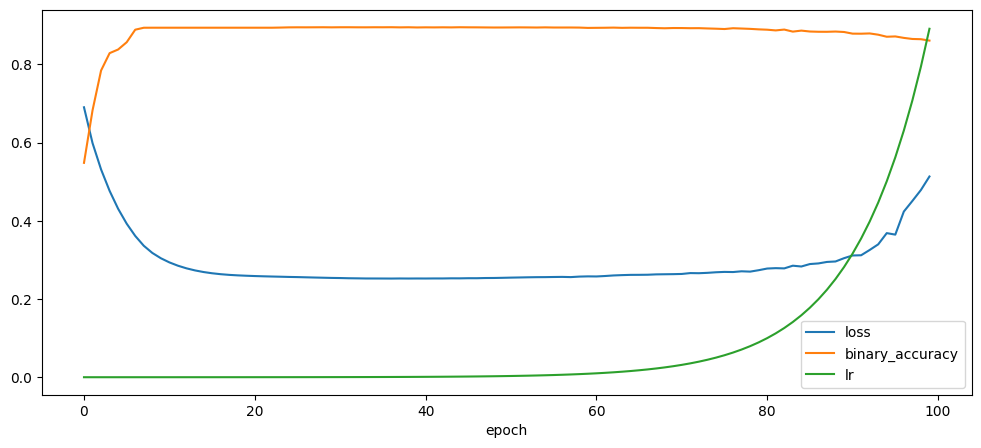

In [ ]:
pd.DataFrame(history.history)[["loss", "binary_accuracy",	"lr"]].plot(figsize= (12, 5), xlabel="epoch")

Text(0.5, 1.0, 'Learning rate vs loss')

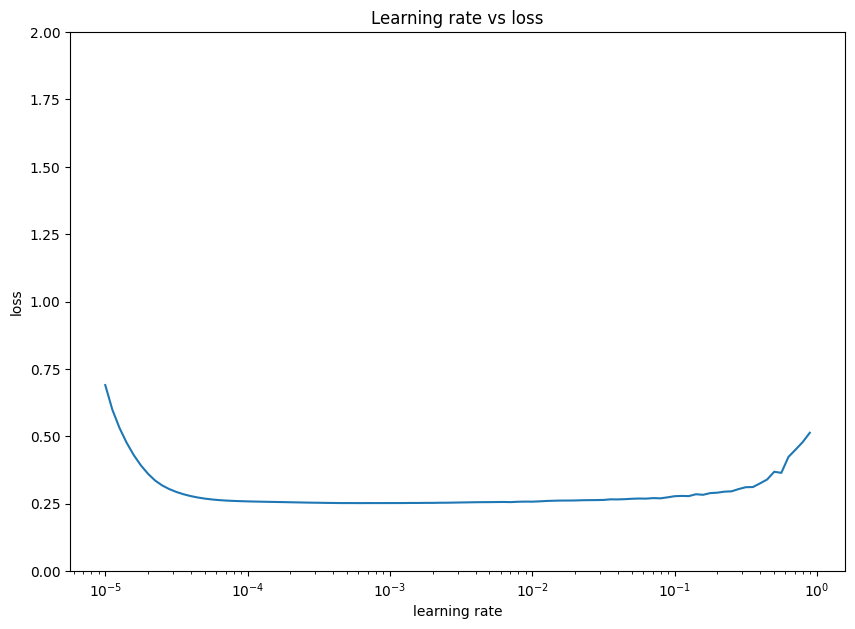

In [ ]:
import matplotlib.pyplot as plt

# plot perbandingan learningrate dengan loss
learning_rate_schedule= 1e-5 * 10**(np.arange(100)/20)
plt.figure(figsize= (10, 7))
plt.semilogx(learning_rate_schedule, history.history["loss"]) # Dengan demikan learningrate akan diterapkan log-scale
plt.ylim([0, 2])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Learning rate vs loss")

Berarti kita memakain learning rate `1e-4`

In [ ]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_7.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])


history = model_7.fit(X_train, Y_train, epochs= 1000, verbose= 1)

Epoch 1/1000
407/407 [==============================] - 6s 4ms/step - loss: 0.4489 - binary_crossentropy: 0.4489 - binary_accuracy: 0.8333
Epoch 2/1000
407/407 [==============================] - 2s 4ms/step - loss: 0.3115 - binary_crossentropy: 0.3115 - binary_accuracy: 0.8937
Epoch 3/1000
407/407 [==============================] - 2s 4ms/step - loss: 0.2841 - binary_crossentropy: 0.2841 - binary_accuracy: 0.8937
Epoch 4/1000
407/407 [==============================] - 2s 4ms/step - loss: 0.2725 - binary_crossentropy: 0.2725 - binary_accuracy: 0.8937
Epoch 5/1000
407/407 [==============================] - 2s 4ms/step - loss: 0.2667 - binary_crossentropy: 0.2667 - binary_accuracy: 0.8937
Epoch 6/1000
407/407 [==============================] - 2s 4ms/step - loss: 0.2635 - binary_crossentropy: 0.2635 - binary_accuracy: 0.8937
Epoch 7/1000
407/407 [==============================] - 2s 6ms/step - loss: 0.2617 - binary_crossentropy: 0.2617 - binary_accuracy: 0.8937
Epoch 8/1000
407/407 [=====

<Axes: xlabel='epoch'>

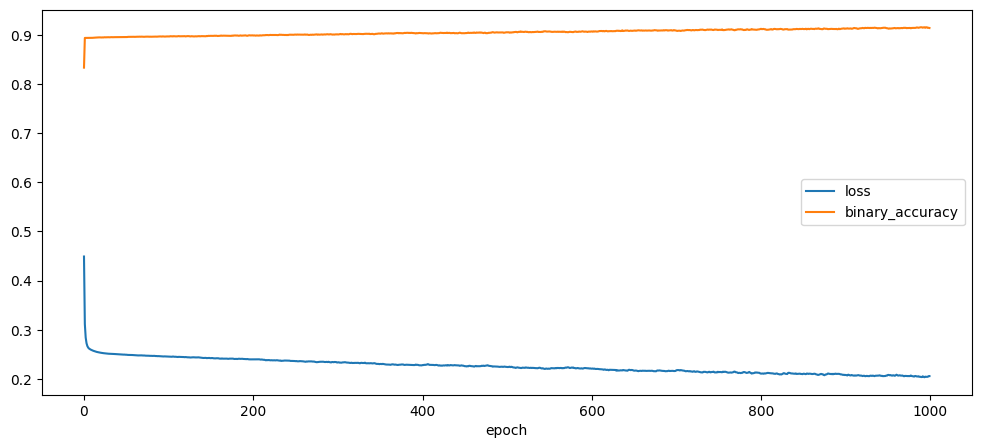

In [ ]:
pd.DataFrame(history.history)[["loss", "binary_accuracy"]].plot(figsize= (12, 5), xlabel="epoch")

## Model Evaluation

In [ ]:
model_7.evaluate(X_test, Y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.3054 - binary_crossentropy: 0.3054 - binary_accuracy: 0.8777


[0.3053547441959381, 0.3053547441959381, 0.877703845500946]

In [ ]:
model_7.predict(tf.expand_dims(X_test[1], axis= 0))

1/1 [==============================] - 0s 263ms/step


array([[0.28137502, 0.37246177, 0.28665313, 0.16376227, 0.15322782,
        0.02962962, 0.02331306, 0.30057272, 0.01124436, 0.01008832,
        0.01203473, 0.02769211]], dtype=float32)

In [ ]:
Y_test[1]

<tf.Tensor: shape=(12,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
result = model_7.predict(X_test)
conv_result = (result >= 0.5).astype(int)
# conv_result

19/19 [==============================] - 0s 3ms/step


In [ ]:
cm = multilabel_confusion_matrix(Y_test, conv_result)
print("Confusion Matrix:")
print(cm)
# print(classification_report(Y_test, conv_result))

Confusion Matrix:
[[[295 102]
  [133  71]]

 [[374  65]
  [126  36]]

 [[465  26]
  [106   4]]

 [[557   2]
  [ 42   0]]

 [[572   2]
  [ 27   0]]

 [[587   1]
  [ 13   0]]

 [[588   0]
  [ 13   0]]

 [[369  61]
  [142  29]]

 [[600   0]
  [  1   0]]

 [[597   0]
  [  4   0]]

 [[594   0]
  [  7   0]]

 [[592   0]
  [  9   0]]]


In [ ]:
model_7.save("Threath_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
load_model = tf.keras.models.load_model("Threath_model.h5")

In [ ]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 100)               39100     
                                                                 
 hidden_layer2 (Dense)       (None, 50)                5050      
                                                                 
 hidden_layer3 (Dense)       (None, 20)                1020      
                                                                 
 output (Dense)              (None, 12)                252       
                                                                 
Total params: 45422 (177.43 KB)
Trainable params: 45422 (177.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
load_model.predict(X_test)

19/19 [==============================] - 0s 2ms/step


array([[3.83230805e-01, 1.19422480e-01, 3.27691585e-01, ...,
        4.91924817e-04, 2.78865593e-03, 3.47325788e-03],
       [2.81389296e-01, 3.72465968e-01, 2.86651522e-01, ...,
        1.00874770e-02, 1.20329959e-02, 2.76896171e-02],
       [3.29825222e-01, 1.83638036e-01, 3.78827453e-02, ...,
        1.04804933e-02, 5.39653236e-03, 1.30500896e-02],
       ...,
       [1.36564046e-01, 2.06498504e-01, 2.44085595e-01, ...,
        1.49166118e-02, 2.00019218e-02, 2.63805166e-02],
       [2.07983211e-01, 8.47406015e-02, 1.01584114e-01, ...,
        3.58154532e-04, 6.64992782e-04, 6.39559235e-04],
       [4.05678540e-01, 3.15241843e-01, 4.07752432e-02, ...,
        1.00183645e-02, 2.96752341e-03, 1.65741257e-02]], dtype=float32)

In [ ]:
result = load_model.predict(X_test)
conv_result = (result >= 0.3).astype(int)
cm = multilabel_confusion_matrix(Y_test, conv_result)
print("Confusion Matrix:")
print(cm)
# print(classification_report(Y_test, conv_result))

19/19 [==============================] - 0s 3ms/step
Confusion Matrix:
[[[195 202]
  [ 85 119]]

 [[303 136]
  [ 94  68]]

 [[418  73]
  [ 93  17]]

 [[548  11]
  [ 41   1]]

 [[568   6]
  [ 25   2]]

 [[586   2]
  [ 13   0]]

 [[588   0]
  [ 13   0]]

 [[287 143]
  [ 98  73]]

 [[600   0]
  [  1   0]]

 [[596   1]
  [  4   0]]

 [[594   0]
  [  7   0]]

 [[592   0]
  [  9   0]]]


Use `**0.2**` threshold for clasificate True value



## With data cleaning

In [ ]:
df = pd.read_csv(f"{DataPath}concanate.csv")

In [ ]:
df.drop(columns = 'Unnamed: 0', inplace= True)

In [ ]:
df

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
0,- disaat semua cowok berusaha melacak perhatia...,1,1,0,0,0,0,0,1,0,0,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,1,0,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13596,Semua orang kacau karena hal aneh ini karena k...,0,0,1,0,0,0,1,0,1,0,0,0
13597,Sebenarnya orang-orang aneh ini sangat kuat me...,0,1,0,0,0,0,0,0,0,1,0,0
13598,Aku juga seorang pendeta arab seperti ini kede...,0,0,1,1,0,0,0,0,0,0,0,0
13599,Jadi kau bercinta dengan saudaramu bukan denga...,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
df = df.sample(frac= 1, random_state= 101)
df.head()

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
3446,RT USER: Anies: Ombudsman Perwakilan itu TIDAK...,0,0,0,0,0,0,0,0,0,0,0,0
12313,Nama Lengkap : Iris Jung\n\nNama Asli : Jung A...,0,0,0,0,0,0,0,0,0,0,0,0
3449,"Angkat Tradisi dan Budaya, Rakyat Banyuwangi K...",0,0,0,0,0,0,0,0,0,0,0,0
9060,USER USER USER Pintar tapi itu tugas utama pem...,0,0,0,0,0,0,0,0,0,0,0,0
7514,ada perek yang imagine nya liar? Yg longrep ga...,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X, Y = df.iloc[:, :1].values, df.iloc[:, 1:].values
X, Y= np.squeeze(X), np.squeeze(Y)


In [ ]:
len(X), len(Y)

(13601, 13601)

In [ ]:
np.shape(X), np.shape(Y)

((13601,), (13601, 12))

In [ ]:
X, Y = X.tolist(), Y.tolist()

In [ ]:
def preprocess(sentence:list):
  # case Folding
  sentences = [sentence.lower() for sentence in sentence]
  # print(sentences)


  # tokenizer
  tokenizer     = RegexpTokenizer(r'\w+')
  # hasil_token   = tokenizer.tokenize(sentences[1])
  token_sentence = [tokenizer.tokenize(sentence) for sentence in sentences]
  # print(token_sentence)


  # ah, al, ala, an, and, as, atau, awal, be, ber, bin, bro, bu, bung, but, by, cak, cc, dan, deh, dengan, di, dil, dong, dua, eh, fadli, fahri
  # fan, for, front, full, harto, hasan, he, hehe, hem, ia, ih, in, is, itu, iya, je, juga, kah, kak, kan, kang, kat, "kau", ke, km, kok, ku, ky
  # lah, like, lima, live, "lo", me, mei, men, min, mk, mu, my, nah, nak, namun, nek, nih, no, nya, of, oh, oi, oke, -pada, pak, per, ppp, pun, ra
  # rang, rt, sa, se, seba, si, sing, ta, tang, tar, tau, the, ting, to, toh, tomohon, uniform, up, untuk, user, wah, wkwk, ya, yaitu, yakni, yang, zon

  # yuk,yg,yaa,wkwkwk,tdk,so,kyk,ko,jg,jgn,jd,jdi,hrs,haha,gw,gk,ga,ente,emg,elo,dr,dlm,dgn,byk,bkn,aq,ama,aku,adlh,ad

  # ad,adlh,aku,ama,aq,bgt,bkn,blg,bnyk,bs,byk,da,dah,dapet,dapat,dengar,dg,dgn,dll,ga,gmn,gt,gw,haha,hahaha,jd,jdi,jgn,ka,karna,ken,kl,klo,kyk,lg,lho,lu,mmg,mo,msh,ngga,nggak,ntar,yg,yo
  words = """ad,adlh,aku,ama,aq,bgt,bkn,blg,bnyk,bs,byk,da,dah,dapet,dapat,dengar,dg,dgn,dll,ga,gmn,gt,gw,haha,hahaha,jd,jdi,jgn,ka,karna,ken,kl,klo,kyk,lg,lho,lu,mmg,mo,msh,ngga,nggak,ntar,yg,yo,yuk,yg,yaa,wkwkwk,tdk,so,kyk,ko,jg,jgn,jd,jdi,hrs,haha,gw,gk,ga,ente,emg,elo,dr,dlm,dgn,byk,bkn,aq,ama,aku,adlh,ad,gue,aja,aku,pengguna,ah,al,ala,an,and,as,atau,awal,be,ber,bin,bro,bu,bung,but,by,cak,cc,dan,deh,dengan,di,dil,dong,dua,eh,fadli,fahri,fan,for,front,full,harto,hasan,he,hehe,hem,ia,ih,in,is,itu,iya,je,juga,kah,kak,kan,kang,kat,kau,ke,km,kok,ku,ky,lah,like,lima,live,lo,me,mei,men,min,mk,mu,my,nah,nak,namun,nek,nih,no,nya,of,oh,oi,oke,pak,per,ppp,pun,ra,rang,rt,sa,se,seba,si,sing,ta,tang,tar,ter,tau,the,ting,to,toh,tomohon,uniform,up,untuk,user,wah,wkwk,ya,yaitu,yakni,yang,zon"""
  word = words.split(",")
  # word = np.reshape(word, -1)
  # word.tolist()
  # stopword
  wordlist= set(stopwords.words('indonesian') + word)
  sw_sentences = [[word for word in sentence if word not in wordlist]for sentence in token_sentence]
  cleaned_sentences = [' '.join(sentence) for sentence in sw_sentences]
  # print(cleaned_sentences)

  return cleaned_sentences

In [ ]:
X = preprocess(X)

### Embedding data

In [ ]:
import tensorflow as tf


In [ ]:
from transformers import BertTokenizer, TFBertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)



Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# encode text
X_encode_input= tokenizer(X, padding= True, truncation=True, max_length=512, return_tensors="tf")

In [ ]:
Y_tensor = tf.constant(Y)

In [ ]:
Y_tensor.shape

TensorShape([13601, 12])

In [ ]:
X_encode_input

{'input_ids': <tf.Tensor: shape=(13601, 276), dtype=int32, numpy=
array([[    3, 31941,  5611, ...,     2,     2,     2],
       [    3,  1769,  5036, ...,     2,     2,     2],
       [    3, 11133,  2810, ...,     2,     2,     2],
       ...,
       [    3, 16093,  1538, ...,     2,     2,     2],
       [    3,    47,  3134, ...,     2,     2,     2],
       [    3, 30768,  4642, ...,     2,     2,     2]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(13601, 276), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13601, 276), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
X_encode_input['input_ids'].shape

TensorShape([13601, 276])

In [ ]:
n_classes = len(Y_tensor[0])

### Split data

In [ ]:
X_train, X_test = X_encode_input['input_ids'][:13000], X_encode_input['input_ids'][13000:]

In [ ]:
Y_train, Y_test = Y_tensor[:13000], Y_tensor[13000:]

In [ ]:
len(X_train), len(X_test)

(13000, 601)

In [ ]:
len(Y_train), len(Y_test)

(13000, 601)

### Build Model

In [ ]:
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_8.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])


history2 = model_8.fit(X_train, Y_train, epochs= 100, verbose= 1)

Epoch 1/100
407/407 [==============================] - 7s 6ms/step - loss: 0.4895 - binary_crossentropy: 0.4895 - binary_accuracy: 0.7902
Epoch 2/100
407/407 [==============================] - 3s 7ms/step - loss: 0.3230 - binary_crossentropy: 0.3230 - binary_accuracy: 0.8921
Epoch 3/100
407/407 [==============================] - 2s 4ms/step - loss: 0.2860 - binary_crossentropy: 0.2860 - binary_accuracy: 0.8934
Epoch 4/100
407/407 [==============================] - 2s 4ms/step - loss: 0.2724 - binary_crossentropy: 0.2724 - binary_accuracy: 0.8934
Epoch 5/100
407/407 [==============================] - 2s 4ms/step - loss: 0.2662 - binary_crossentropy: 0.2662 - binary_accuracy: 0.8934
Epoch 6/100
407/407 [==============================] - 2s 6ms/step - loss: 0.2632 - binary_crossentropy: 0.2632 - binary_accuracy: 0.8934
Epoch 7/100
407/407 [==============================] - 2s 6ms/step - loss: 0.2615 - binary_crossentropy: 0.2615 - binary_accuracy: 0.8934
Epoch 8/100
407/407 [=============

#### Evaluation
> looks like cleaned dataset not impact to the accuracy

## Try new sentence

In [ ]:
load_model = tf.keras.models.load_model("Bert_Threath_model.h5")
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 100)               39100     
                                                                 
 hidden_layer2 (Dense)       (None, 50)                5050      
                                                                 
 hidden_layer3 (Dense)       (None, 20)                1020      
                                                                 
 output (Dense)              (None, 12)                252       
                                                                 
Total params: 45422 (177.43 KB)
Trainable params: 45422 (177.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_sentence = "Anjing kali lah kau china"


In [ ]:
# encode text
# X_encode_input= tokenizer(X, padding= True, truncation=True, max_length=512, return_tensors="tf")

In [ ]:
encode_input = tf.squeeze(tokenizer(test_sentence, padding= True, truncation=True, max_length=512, return_tensors="tf")['input_ids'])
encode_input

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([    3,  5852,  1859,  2381, 10900,  5331,     1], dtype=int32)>

In [ ]:
# Mengubah bentuk tensor menjadi (32,)
tensor_hasil = tf.pad(encode_input, paddings=[[0, 390-len(encode_input)]], constant_values=2)

# Mencetak tensor hasil
# tensor_hasil

In [ ]:
# tf.expand_dims(tensor_hasil, axis= 0)

In [ ]:
klasifikasi_threath = load_model.predict(tf.expand_dims(tensor_hasil, axis= 0))
klasifikasi_threath

1/1 [==============================] - 0s 119ms/step


array([[0.46222138, 0.27603826, 0.09562095, 0.02478572, 0.03206427,
        0.00690401, 0.11932465, 0.20109639, 0.01012821, 0.00208055,
        0.00770209, 0.03079296]], dtype=float32)

In [ ]:
label = ["Abusive",	"HS_Individual",	"HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "sexual_orientation", "disability", "national_origin", "violence"]
conv_result = (klasifikasi_threath >= 0.01).astype(int)
conv_result

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]])

In [ ]:
indeks_bernilai_1 = [i for i, nilai in enumerate(conv_result[0]) if nilai == 1]

print(indeks_bernilai_1)

[0, 1, 2, 3, 4, 6, 7, 8, 11]


In [ ]:
nilai_yang_diambil = [label[i] for i in indeks_bernilai_1]

print(nilai_yang_diambil)


['Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Gender', 'HS_Other', 'sexual_orientation', 'violence']


## Preprocessing data
Imbalance data impact performance of model. we've got 91% accuracy, but the performance it's not good when test with new data. `let's handle imbalance data`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DataPath = "/content/drive/MyDrive/Magang/ThreatDetection/Data/"

In [ ]:
df = pd.read_csv(f"{DataPath}concanate.csv")

In [ ]:
df.drop(columns = 'Unnamed: 0', inplace= True)

In [ ]:
df.iloc[:, 1:]

In [ ]:
jumlahNilaiTiapColumn = df.iloc[:, 1:].sum()
jumlahNilaiTiapColumn

In [ ]:
fig = px.bar(data_frame= jumlahNilaiTiapColumn, x = jumlahNilaiTiapColumn.index, y = jumlahNilaiTiapColumn.values,
             title = "jumlah nilai setiap column", labels = {'y' : "jumlah", 'index' : "nama column"})
fig.update_xaxes(tickangle=90)
fig.show()

In [ ]:
jumlahNilaiTiapColumn.index

Index(['Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'sexual_orientation',
       'disability', 'national_origin', 'violence'],
      dtype='object')

### Get Data
This is the step to handle the data imbalance in this case:

* we take every column which have 1 value.
* make 1000 sample in every column.
* concat every dataframe we have taken.
* Replace Nan value with 0.
* we randomize dataset.


In [ ]:
df_Abusive = df[df['Abusive'] == 1].iloc[:, [0,1]]
df_HS_Individual = df[df['HS_Individual'] == 1].iloc[:, [0,2]]
df_HS_Group = df[df['HS_Group'] == 1].iloc[:, [0,3]]
df_HS_Religion = df[df['HS_Religion'] == 1].iloc[:, [0,4]]
df_HS_Race = df[df['HS_Race'] == 1].iloc[:, [0,5]]
df_HS_Physical = df[df['HS_Physical'] == 1].iloc[:, [0,6]]
df_HS_Gender = df[df['HS_Gender'] == 1].iloc[:, [0,7]]
df_HS_Other = df[df['HS_Other'] == 1].iloc[:, [0,8]]
df_sexual_orientation = df[df['sexual_orientation'] == 1].iloc[:, [0,9]]
df_disability = df[df['disability'] == 1].iloc[:, [0,10]]
df_national_origin = df[df['national_origin'] == 1].iloc[:, [0,11]]
df_violence = df[df['violence'] == 1].iloc[:, [0,12]]


df_Abusive = df_Abusive.sample(1000, replace= True)
df_HS_Individual = df_HS_Individual.sample(1000, replace= True)
df_HS_Group = df_HS_Group.sample(1000, replace= True)
df_HS_Religion = df_HS_Religion.sample(1000, replace= True)
df_HS_Race = df_HS_Race.sample(1000, replace= True)
df_HS_Physical = df_HS_Physical.sample(1000, replace= True)
df_HS_Gender = df_HS_Gender.sample(1000, replace= True)
df_HS_Other = df_HS_Other.sample(1000, replace= True)
df_sexual_orientation = df_sexual_orientation.sample(1000, replace= True)
df_disability = df_disability.sample(1000, replace= True)
df_national_origin = df_national_origin.sample(1000, replace= True)
df_violence = df_violence.sample(1000, replace= True)


In [ ]:
print("df_Abusive shape :",df_Abusive.shape)
print("df_HS_Individual shape :",df_HS_Individual.shape)
print("df_HS_Group shape :",df_HS_Group.shape)
print("df_HS_Religion shape :",df_HS_Religion.shape)
print("df_HS_Race shape :",df_HS_Race.shape)
print("df_HS_Physical shape :",df_HS_Physical.shape)
print("df_HS_Gender shape :",df_HS_Gender.shape)
print("df_HS_Other shape :",df_HS_Other.shape)
print("df_sexual_orientation shape :",df_sexual_orientation.shape)
print("df_disability shape :",df_disability.shape)
print("df_national_origin shape :",df_national_origin.shape)
print("df_violence shape :",df_violence.shape)

df_Abusive shape : (1000, 2)
df_HS_Individual shape : (1000, 2)
df_HS_Group shape : (1000, 2)
df_HS_Religion shape : (1000, 2)
df_HS_Race shape : (1000, 2)
df_HS_Physical shape : (1000, 2)
df_HS_Gender shape : (1000, 2)
df_HS_Other shape : (1000, 2)
df_sexual_orientation shape : (1000, 2)
df_disability shape : (1000, 2)
df_national_origin shape : (1000, 2)
df_violence shape : (1000, 2)


In [ ]:
df_concate = pd.concat([df_Abusive,df_HS_Individual,df_HS_Group,df_HS_Religion,df_HS_Race,df_HS_Physical,df_HS_Gender,df_HS_Other,df_sexual_orientation,df_disability,df_national_origin,df_violence])
df_concate

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
5631,RT USER: CENGENG LU TAI URL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10998,Begal Arab Buta Huruf malah dinabikan USER Beg...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12901,USER Alaaaah...kyak ente berhasil aja USER ..c...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,Kekasih dumay\n\n\xf0\x9f\x91\xa6: kalo aku ka...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,USER USER USER USER USER USER USER USER USER U...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13339,Kau seharusnya lebih kejam pada orang yang men...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
13581,Pergi pemutih sendiri boneka vagina hitam dan ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
13297,"Setiap kali aku melihatnya dengan hijab, niqab...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
13313,Buddhisme adalah agama untuk sapi. orang-orang...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
df_concate.fillna(0, inplace= True)

In [ ]:
df_1= df_concate.sample(frac= 1, random_state= 42)

In [ ]:
df_1= df_1.convert_dtypes()

In [ ]:
df_1.head()

,text,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,sexual_orientation,disability,national_origin,violence
8497,USER USER USER Bencong teriak bencong',0,1,0,0,0,0,0,0,0,0,0,0
13574,aku tidak bisa berdiri feminis aku suka pria y...,0,0,0,0,0,0,1,0,0,0,0,0
12193,Dulu katanya jangan pilih pak prabowo beliau d...,0,1,0,0,0,0,0,0,0,0,0,0
13407,Dia adalah autistik teraneh yang pernah saya l...,0,0,0,0,0,0,0,0,0,1,0,0
458,USER USER USER kafir haram jadi pemimpin nyet',1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
jumlahNilaiTiapColumn = df_1.iloc[:, 1:].sum()
jumlahNilaiTiapColumn

Abusive               1000
HS_Individual         1000
HS_Group              1000
HS_Religion           1000
HS_Race               1000
HS_Physical           1000
HS_Gender             1000
HS_Other              1000
sexual_orientation    1000
disability            1000
national_origin       1000
violence              1000
dtype: int64

In [ ]:
fig = px.bar(data_frame= jumlahNilaiTiapColumn, x = jumlahNilaiTiapColumn.index, y = jumlahNilaiTiapColumn.values,
             title = "jumlah nilai setiap column", labels = {'y' : "jumlah", 'index' : "nama column"})
fig.update_xaxes(tickangle=90)
fig.show()

### Encode

In [ ]:
X, Y = df_1.iloc[:, :1].values, df_1.iloc[:, 1:].values
X, Y= np.squeeze(X), np.squeeze(Y)


In [ ]:
len(X), len(Y)

(12000, 12000)

In [ ]:
np.shape(X), np.shape(Y)

((12000,), (12000, 12))

In [ ]:
X, Y = X.tolist(), Y.tolist()

### Using Bert Transformers to embedding

In [ ]:


model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)



Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# encode text
X_encode_input= tokenizer(X, padding= True, truncation=True, max_length=512, return_tensors="tf")

In [ ]:
X_encode_input

{'input_ids': <tf.Tensor: shape=(12000, 210), dtype=int32, numpy=
array([[    3, 18992, 18992, ...,     2,     2,     2],
       [    3,  4384,  1653, ...,     2,     2,     2],
       [    3,  5395, 11639, ...,     2,     2,     2],
       ...,
       [    3, 18992, 18992, ...,     2,     2,     2],
       [    3, 18992, 18992, ...,     2,     2,     2],
       [    3, 18992, 18992, ...,     2,     2,     2]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(12000, 210), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(12000, 210), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
Y_tensor = tf.constant(Y)

In [ ]:
Y_tensor.shape

TensorShape([12000, 12])

In [ ]:
X_encode_input['input_ids'].shape

TensorShape([12000, 210])

In [ ]:
n_classes = len(Y_tensor[0])
n_classes

12

In [ ]:
len(X_encode_input['input_ids']), len(Y_tensor)

(12000, 12000)

### Split Dataset

In [ ]:
X_train, X_test = X_encode_input['input_ids'][:11000], X_encode_input['input_ids'][11000:]

In [ ]:
Y_train, Y_test = Y_tensor[:11000], Y_tensor[11000:]

In [ ]:
len(X_train), len(X_test)

(11000, 1000)

In [ ]:
len(Y_train), len(Y_test)

(11000, 1000)

### Build Model

#### Learning rate Experiment

In [ ]:
model_v2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_v2.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

lr_schaduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20)) # Dari learning rate 0.00001 akan terus meningkat seiring pertambahan

history = model_v2.fit(X_train, Y_train, epochs= 100, verbose= 1, callbacks= lr_schaduler)

Epoch 1/100
344/344 [==============================] - 8s 6ms/step - loss: 0.7681 - binary_crossentropy: 0.7681 - binary_accuracy: 0.4299 - lr: 1.0000e-05
Epoch 2/100
344/344 [==============================] - 2s 6ms/step - loss: 0.6682 - binary_crossentropy: 0.6682 - binary_accuracy: 0.5943 - lr: 1.1220e-05
Epoch 3/100
344/344 [==============================] - 2s 7ms/step - loss: 0.5908 - binary_crossentropy: 0.5908 - binary_accuracy: 0.7356 - lr: 1.2589e-05
Epoch 4/100
344/344 [==============================] - 3s 8ms/step - loss: 0.5323 - binary_crossentropy: 0.5323 - binary_accuracy: 0.8187 - lr: 1.4125e-05
Epoch 5/100
344/344 [==============================] - 4s 11ms/step - loss: 0.4851 - binary_crossentropy: 0.4851 - binary_accuracy: 0.8664 - lr: 1.5849e-05
Epoch 6/100
344/344 [==============================] - 4s 10ms/step - loss: 0.4456 - binary_crossentropy: 0.4456 - binary_accuracy: 0.8905 - lr: 1.7783e-05
Epoch 7/100
344/344 [==============================] - 2s 7ms/step -

In [ ]:
pd.DataFrame(history.history)[["loss", "binary_accuracy",	"lr"]]

,loss,binary_accuracy,lr
0,0.768150,0.429909,0.000010
1,0.668236,0.594303,0.000011
2,0.590792,0.735598,0.000013
3,0.532323,0.818735,0.000014
4,0.485085,0.866356,0.000016
...,...,...,...
95,0.401031,0.905462,0.562341
96,0.433930,0.898712,0.630957
97,0.447340,0.896379,0.707946
98,0.504030,0.890470,0.794328


<Axes: xlabel='epoch'>

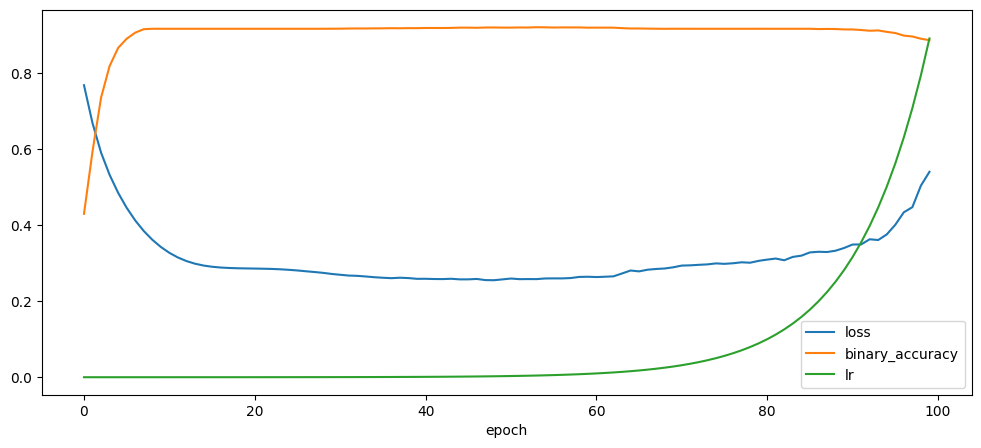

In [ ]:
pd.DataFrame(history.history)[["loss", "binary_accuracy",	"lr"]].plot(figsize= (12, 5), xlabel="epoch")

Text(0.5, 1.0, 'Learning rate vs loss')

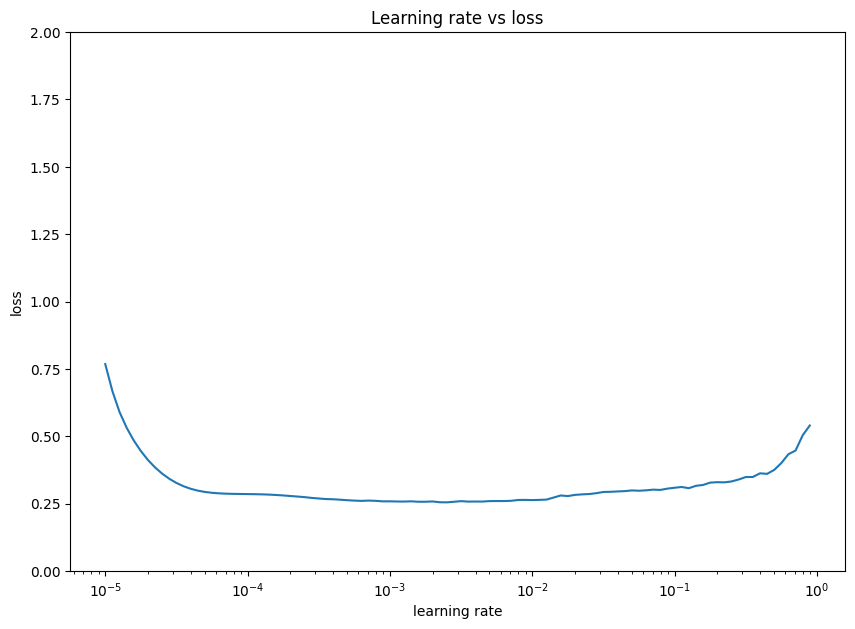

In [ ]:
import matplotlib.pyplot as plt

# plot perbandingan learningrate dengan loss
learning_rate_schedule= 1e-5 * 10**(np.arange(100)/20)
plt.figure(figsize= (10, 7))
plt.semilogx(learning_rate_schedule, history.history["loss"]) # Dengan demikan learningrate akan diterapkan log-scale
plt.ylim([0, 2])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Learning rate vs loss")

let's take 1e-3

### Train Model

In [ ]:
model_v2_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_v2_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

history = model_v2_1.fit(X_train, Y_train, epochs= 1000, verbose= 1)

Epoch 1/1000
344/344 [==============================] - 3s 4ms/step - loss: 0.3109 - binary_crossentropy: 0.3109 - binary_accuracy: 0.9097
Epoch 2/1000
344/344 [==============================] - 1s 4ms/step - loss: 0.2837 - binary_crossentropy: 0.2837 - binary_accuracy: 0.9167
Epoch 3/1000
344/344 [==============================] - 2s 5ms/step - loss: 0.2784 - binary_crossentropy: 0.2784 - binary_accuracy: 0.9167
Epoch 4/1000
344/344 [==============================] - 2s 6ms/step - loss: 0.2760 - binary_crossentropy: 0.2760 - binary_accuracy: 0.9167
Epoch 5/1000
344/344 [==============================] - 2s 6ms/step - loss: 0.2753 - binary_crossentropy: 0.2753 - binary_accuracy: 0.9167
Epoch 6/1000
344/344 [==============================] - 1s 4ms/step - loss: 0.2742 - binary_crossentropy: 0.2742 - binary_accuracy: 0.9167
Epoch 7/1000
344/344 [==============================] - 1s 4ms/step - loss: 0.2730 - binary_crossentropy: 0.2730 - binary_accuracy: 0.9167
Epoch 8/1000
344/344 [=====

In [ ]:
model_v2_1.save("Threath_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
from google.colab import files
files.download('Threath_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train all data

In [ ]:
len(X), len(Y)

(12000, 12000)

In [ ]:
model_v2_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(n_classes, activation= "sigmoid", name= "output")
])

model_v2_2.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])

history = model_v2_2.fit(X_encode_input['input_ids'], Y_tensor, epochs= 1000, verbose= 1)

Epoch 1/1000
375/375 [==============================] - 6s 5ms/step - loss: 0.3138 - binary_crossentropy: 0.3138 - binary_accuracy: 0.9063
Epoch 2/1000
375/375 [==============================] - 2s 5ms/step - loss: 0.2814 - binary_crossentropy: 0.2814 - binary_accuracy: 0.9167
Epoch 3/1000
375/375 [==============================] - 2s 5ms/step - loss: 0.2768 - binary_crossentropy: 0.2768 - binary_accuracy: 0.9167
Epoch 4/1000
375/375 [==============================] - 2s 6ms/step - loss: 0.2742 - binary_crossentropy: 0.2742 - binary_accuracy: 0.9167
Epoch 5/1000
375/375 [==============================] - 1s 3ms/step - loss: 0.2716 - binary_crossentropy: 0.2716 - binary_accuracy: 0.9167
Epoch 6/1000
375/375 [==============================] - 1s 3ms/step - loss: 0.2690 - binary_crossentropy: 0.2690 - binary_accuracy: 0.9169
Epoch 7/1000
375/375 [==============================] - 2s 5ms/step - loss: 0.2672 - binary_crossentropy: 0.2672 - binary_accuracy: 0.9170
Epoch 8/1000
375/375 [=====

In [ ]:
model_v2_2.save("Bert_Threath_modelv2.h5")

In [ ]:
from google.colab import files
files.download('Bert_Threath_modelv2.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [ ]:
result = model_v2_1.predict(X_test)
conv_result = (result >= 0.5).astype(int)
# conv_result

32/32 [==============================] - 0s 2ms/step


In [ ]:
cm = multilabel_confusion_matrix(Y_test, conv_result)
print("Confusion Matrix:")
print(cm)
# print(classification_report(Y_test, conv_result))

Confusion Matrix:
[[[924   1]
  [ 74   1]]

 [[915   5]
  [ 79   1]]

 [[922   4]
  [ 74   0]]

 [[923   3]
  [ 67   7]]

 [[907   4]
  [ 78  11]]

 [[897   8]
  [ 86   9]]

 [[903   6]
  [ 72  19]]

 [[900   0]
  [100   0]]

 [[917  12]
  [ 46  25]]

 [[910  21]
  [ 35  34]]

 [[896  22]
  [ 46  36]]

 [[894   6]
  [ 88  12]]]


In [ ]:
Y_test

<tf.Tensor: shape=(1000, 12), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
result = model_v2_2.predict(X_encode_input['input_ids'])
conv_result = (result >= 0.5).astype(int)
# conv_result

375/375 [==============================] - 1s 3ms/step


In [ ]:
cm = multilabel_confusion_matrix(Y_tensor, conv_result)
print("Confusion Matrix:")
print(cm)
# print(classification_report(Y_test, conv_result))

Confusion Matrix:
[[[10999     1]
  [  979    21]]

 [[10993     7]
  [  978    22]]

 [[10972    28]
  [  956    44]]

 [[10975    25]
  [  873   127]]

 [[10957    43]
  [  831   169]]

 [[10898   102]
  [  797   203]]

 [[10928    72]
  [  722   278]]

 [[10983    17]
  [  975    25]]

 [[10904    96]
  [  576   424]]

 [[10896   104]
  [  460   540]]

 [[10790   210]
  [  500   500]]

 [[10882   118]
  [  764   236]]]


In [ ]:
Y_test

<tf.Tensor: shape=(1000, 12), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

### Demo

In [ ]:
load_model = tf.keras.models.load_model("Bert_Threath_model.h5")
load_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 100)               21100     
                                                                 
 hidden_layer2 (Dense)       (None, 50)                5050      
                                                                 
 hidden_layer3 (Dense)       (None, 20)                1020      
                                                                 
 output (Dense)              (None, 12)                252       
                                                                 
Total params: 27422 (107.12 KB)
Trainable params: 27422 (107.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_sentence = "Aku bunuh dia nanti"


In [ ]:
encode_input = tf.squeeze(tokenizer(test_sentence, padding= True, truncation=True, max_length=512, return_tensors="tf")['input_ids'])
encode_input
# Mengubah bentuk tensor menjadi (32,)
tensor_hasil = tf.pad(encode_input, paddings=[[0, 210-len(encode_input)]], constant_values=2)

# Mencetak tensor hasil
# tensor_hasil
klasifikasi_threath = load_model.predict(tf.expand_dims(tensor_hasil, axis= 0))
klasifikasi_threath[0]
klasifikasi_threath >= 0.1
label = ["Abusive",	"HS_Individual",	"HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "sexual_orientation", "disability", "national_origin", "violence"]
conv_result = (klasifikasi_threath >= 0.09).astype(int)
conv_result
indeks_bernilai_1 = [i for i, nilai in enumerate(conv_result[0]) if nilai == 1]
nilai_yang_diambil = [label[i] for i in indeks_bernilai_1]

print(nilai_yang_diambil)


1/1 [==============================] - 0s 35ms/step
['violence']


In [ ]:
test_sentence = "Orang China itu memukul orang hitam"

encode_input = tf.squeeze(tokenizer(test_sentence, padding= True, truncation=True, max_length=512, return_tensors="tf")['input_ids'])
encode_input
# Mengubah bentuk tensor menjadi (32,)
tensor_hasil = tf.pad(encode_input, paddings=[[0, 210-len(encode_input)]], constant_values=2)

# Mencetak tensor hasil
# tensor_hasil
klasifikasi_threath = load_model.predict(tf.expand_dims(tensor_hasil, axis= 0))
klasifikasi_threath[0]
klasifikasi_threath >= 0.1
label = ["Abusive",	"HS_Individual",	"HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "sexual_orientation", "disability", "national_origin", "violence"]
conv_result = (klasifikasi_threath >= 0.09).astype(int)
conv_result
indeks_bernilai_1 = [i for i, nilai in enumerate(conv_result[0]) if nilai == 1]
nilai_yang_diambil = [label[i] for i in indeks_bernilai_1]

print(nilai_yang_diambil)

1/1 [==============================] - 0s 31ms/step
['HS_Individual', 'HS_Other']


In [ ]:
load_model = tf.keras.models.load_model("Bert_Threath_modelv2.h5")
load_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (32, 100)                 21100     
                                                                 
 hidden_layer2 (Dense)       (32, 50)                  5050      
                                                                 
 hidden_layer3 (Dense)       (32, 20)                  1020      
                                                                 
 output (Dense)              (32, 12)                  252       
                                                                 
Total params: 27422 (107.12 KB)
Trainable params: 27422 (107.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_sentence = "Aku bunuh dia nanti"


In [ ]:
encode_input = tf.squeeze(tokenizer(test_sentence, padding= True, truncation=True, max_length=512, return_tensors="tf")['input_ids'])
encode_input
# Mengubah bentuk tensor menjadi (32,)
tensor_hasil = tf.pad(encode_input, paddings=[[0, 210-len(encode_input)]], constant_values=2)

# Mencetak tensor hasil
# tensor_hasil
klasifikasi_threath = load_model.predict(tf.expand_dims(tensor_hasil, axis= 0))
klasifikasi_threath[0]
klasifikasi_threath >= 0.1
label = ["Abusive",	"HS_Individual",	"HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "sexual_orientation", "disability", "national_origin", "violence"]
conv_result = (klasifikasi_threath >= 0.09).astype(int)
conv_result
indeks_bernilai_1 = [i for i, nilai in enumerate(conv_result[0]) if nilai == 1]
nilai_yang_diambil = [label[i] for i in indeks_bernilai_1]

print(nilai_yang_diambil)


1/1 [==============================] - 0s 61ms/step
['HS_Individual', 'HS_Gender']


In [ ]:
test_sentence = "Orang China itu memukul orang hitam"

encode_input = tf.squeeze(tokenizer(test_sentence, padding= True, truncation=True, max_length=512, return_tensors="tf")['input_ids'])
encode_input
# Mengubah bentuk tensor menjadi (32,)
tensor_hasil = tf.pad(encode_input, paddings=[[0, 210-len(encode_input)]], constant_values=2)

# Mencetak tensor hasil
# tensor_hasil
klasifikasi_threath = load_model.predict(tf.expand_dims(tensor_hasil, axis= 0))
klasifikasi_threath[0]
klasifikasi_threath >= 0.1
label = ["Abusive",	"HS_Individual",	"HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "sexual_orientation", "disability", "national_origin", "violence"]
conv_result = (klasifikasi_threath >= 0.09).astype(int)
conv_result
indeks_bernilai_1 = [i for i, nilai in enumerate(conv_result[0]) if nilai == 1]
nilai_yang_diambil = [label[i] for i in indeks_bernilai_1]

print(nilai_yang_diambil)

1/1 [==============================] - 0s 20ms/step
['HS_Other', 'disability', 'violence']


few dataset kan so impactfull to performance

## Bert Embedding
before we use just tokenizer to do prediction. I thought I was already using Bert, beside I was just using tokenize. now we use bert to do prediction.


In [ ]:
DataPath = "/content/drive/MyDrive/Magang/ThreatDetection/Data/"

In [ ]:
df = pd.read_csv(f"{DataPath}concanate.csv")

In [ ]:
df.drop(columns = 'Unnamed: 0', inplace= True)

In [ ]:
df = df.sample(frac= 1, random_state= 42)


In [ ]:
df.iloc[:, 1:].sum()

In [ ]:
df.iloc[:2000, 1:].sum()

In [ ]:
df.iloc[2000:2600, 1:].sum()

In [ ]:
X, Y = df.iloc[:, :1].values, df.iloc[:, 1:].values
X, Y= np.squeeze(X), np.squeeze(Y)


In [ ]:
len(X), len(Y)

In [ ]:
np.shape(X), np.shape(Y)

In [ ]:
X, Y = X.tolist(), Y.tolist()

### Split Dataset

In [ ]:
X_train, X_test = X[:2000], X[2000:2600]

In [ ]:
Y_train, Y_test = Y[:2000], Y[2000:2600]

In [ ]:
X_val, Y_val = X[2600:], Y[2600:]

In [27]:
len(X_train), len(X_test)

(2000, 600)

In [28]:
len(Y_train), len(Y_test)

(2000, 600)

In [76]:
len(X_val), len(Y_val)

(11001, 11001)

### Preperation

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
from transformers import BertTokenizer, TFBertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lowercase= True)
# model = TFBertModel.from_pretrained(model_name)
# text = "Silakan diganti dengan text apa saja."
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)


In [ ]:
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=12, problem_type="multi_label_classification")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_encode_input = tokenizer(X_train, padding= True, truncation=True, max_length=512, return_tensors="tf" )


In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((dict(X_encode_input), Y_train))


In [ ]:
dataset_train

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(184,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(184,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(184,), dtype=tf.int32, name=None)}, TensorSpec(shape=(12,), dtype=tf.int32, name=None))>

In [ ]:
dataset_train= dataset_train.batch(16)

### Training

In [ ]:
model.compile(loss= tf.keras.losses.binary_crossentropy,
              optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3),
              metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])
hist= model.fit(dataset_train, verbose= 1, epochs= 1)

32/32 [==============================] - 1526s 45s/step - loss: 1.8429 - binary_crossentropy: 1.8429 - binary_accuracy: 0.8643


In [ ]:
model.save_pretrained("Threath_cls_bert")

In [ ]:
!zip -r Threath_cls_bert.zip Threath_cls_bert

  adding: Threath_cls_bert/ (stored 0%)
  adding: Threath_cls_bert/config.json (deflated 57%)
  adding: Threath_cls_bert/tf_model.h5 (deflated 7%)


In [ ]:
from google.colab import files
files.download('Threath_cls_bert')

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('Threath_cls_bert')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at Threath_cls_bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  9228      
                                                                 
Total params: 110,626,572
Trainable params: 110,626,572
Non-trainable params: 0
_________________________________________________________________


### Evaluation

In [ ]:
X_encode_input_test= tokenizer(X_test, padding= True, truncation=True, max_length=512, return_tensors="tf" )


In [ ]:
dataset_test= tf.data.Dataset.from_tensor_slices((dict(X_encode_input_test), Y_test)).batch(16)

In [ ]:
# model.evaluate(dataset_test)

### Predict

In [ ]:
dataset_test_predict= tf.data.Dataset.from_tensor_slices(dict(X_encode_input_test)).batch(16)

In [ ]:
predict= model.predict(dataset_test_predict)

7/7 [==============================] - 60s 8s/step


In [ ]:
idx= 8
print(predict.logits[idx])
print(Y_test[idx])

[ 4.2154436  -1.0256395  -2.5417995  -5.894267   -1.7571672  -3.1816084
 -1.9672288  -0.81467336 -2.3931224  -2.4484425  -3.097274   -1.0973254 ]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
predict.logits[idx]

array([ 4.2154436 , -1.0256395 , -2.5417995 , -5.894267  , -1.7571672 ,
       -3.1816084 , -1.9672288 , -0.81467336, -2.3931224 , -2.4484425 ,
       -3.097274  , -1.0973254 ], dtype=float32)

In [ ]:
X[790]

'RT USER Kebijakan om jokowi yg diktator bukan wajah lugu nya om.'

In [ ]:
Y[790]

[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
X_predict= X[790]
X_predict= tokenizer(X_predict, padding= True, truncation=True, max_length=512, return_tensors="tf" )
X_predict= tf.data.Dataset.from_tensor_slices(dict(X_predict)).batch(16)
Y_predict= model.predict(X_predict)

1/1 [==============================] - 0s 425ms/step


In [ ]:
Y_predict.logits

array([[ 4.215444  , -1.025639  , -2.5417988 , -5.8942647 , -1.7571673 ,
        -3.1816087 , -1.9672288 , -0.81467324, -2.3931236 , -2.4484422 ,
        -3.097274  , -1.0973253 ]], dtype=float32)

> Have not good performance yet. My hipotesis, it's because havent build layer, **we just have bert layer and we have not neural network layer**. briefly, we just do encoding without do any prediction. so let's build model.

## Bert + Neural network

In [49]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [50]:
model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lowercase= True)

In [51]:
model_bert = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=12, problem_type="multi_label_classification")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
X_encode_input_Train = tokenizer(X_train, padding= True, truncation=True, max_length=512, return_tensors="tf" )
dataset_train = tf.data.Dataset.from_tensor_slices((dict(X_encode_input_Train), Y_train)).batch(32)

X_encode_input_Test = tokenizer(X_test, padding= True, truncation=True, max_length=512, return_tensors="tf" )
dataset_test = tf.data.Dataset.from_tensor_slices((dict(X_encode_input_Test), Y_test)).batch(32)

In [111]:
data_val= tokenizer(X_val, padding= True, truncation=True, max_length=512, return_tensors="tf" )
dataset_val = tf.data.Dataset.from_tensor_slices((dict(data_val))).batch(32)

In [53]:
# X_train= model_bert(X_encode_input_Train)
# X_test= model_bert(X_encode_input_Test)

In [54]:
model_bert.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.keras.metrics.BinaryCrossentropy(
                  name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0))

In [55]:
history = model_bert.fit(dataset_train, epochs= 3, verbose= 1, validation_data= dataset_test)

Epoch 1/3
63/63 [==============================] - 163s 1s/step - loss: 0.2855 - binary_crossentropy: 1.4657 - val_loss: 0.2225 - val_binary_crossentropy: 1.0960
Epoch 2/3
63/63 [==============================] - 87s 1s/step - loss: 0.2029 - binary_crossentropy: 1.0258 - val_loss: 0.1825 - val_binary_crossentropy: 0.8069
Epoch 3/3
63/63 [==============================] - 87s 1s/step - loss: 0.1480 - binary_crossentropy: 0.6890 - val_loss: 0.1811 - val_binary_crossentropy: 0.7933


In [56]:
history.history

{'loss': [0.28547632694244385, 0.20293720066547394, 0.1479739099740982],
 'binary_crossentropy': [1.4656902551651,
  1.0258097648620605,
  0.6889815330505371],
 'val_loss': [0.2224540263414383, 0.18252012133598328, 0.18111857771873474],
 'val_binary_crossentropy': [1.0959933996200562,
  0.8068861961364746,
  0.7933031320571899]}

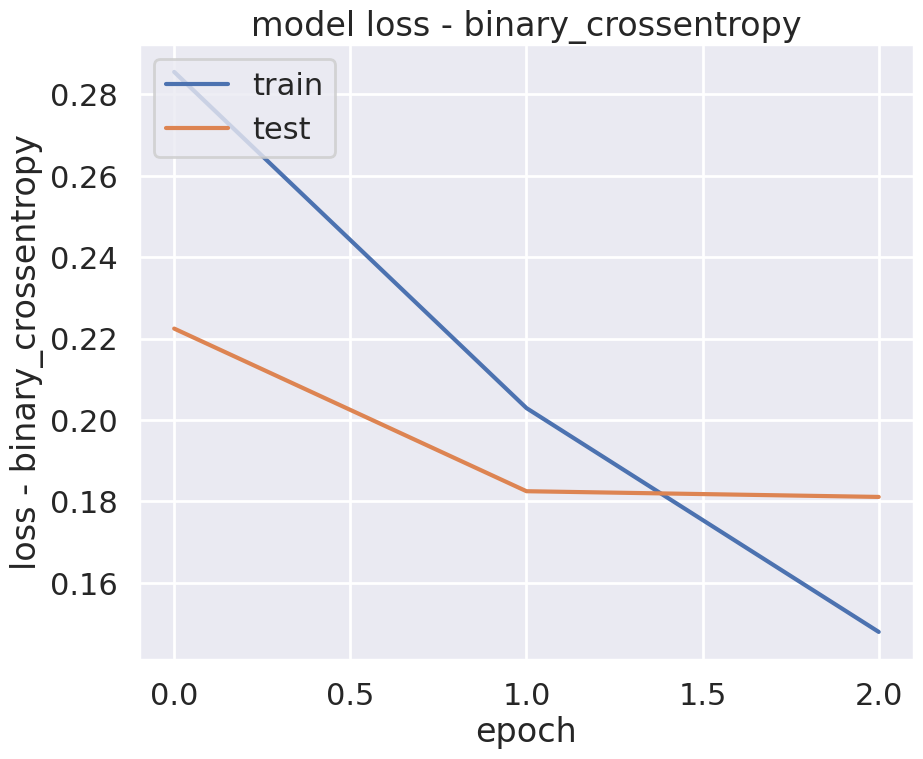

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})


sns.set_context('poster', font_scale = 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - binary_crossentropy')
plt.ylabel('loss - binary_crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
model_bert.save_pretrained("model_bert")

In [80]:
!zip -r model_bert.zip model_bert

  adding: model_bert/ (stored 0%)
  adding: model_bert/tf_model.h5 (deflated 7%)
  adding: model_bert/config.json (deflated 57%)


In [81]:
from google.colab import files
files.download('model_bert.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
y_pred = model_bert.predict(dataset_test)


19/19 [==============================] - 8s 265ms/step


In [72]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = (y_pred[0] >0.50)


print(classification_report(Y_test, y_pred))

roc_auc = roc_auc_score(Y_test, y_pred, average = 'macro')
print(roc_auc)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       232
           1       0.61      0.59      0.60       167
           2       0.59      0.52      0.55        89
           3       0.69      0.48      0.56        42
           4       1.00      0.38      0.55        32
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        14
           7       0.62      0.77      0.69       154
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         5

   micro avg       0.69      0.63      0.66       758
   macro avg       0.36      0.29      0.31       758
weighted avg       0.66      0.63      0.64       758
 samples avg       0.42      0.39      0.39       758

0.6254940822030354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
y_val = model_bert.predict(dataset_val)

344/344 [==============================] - 339s 969ms/step


In [84]:
y_val.logits

array([[-2.1190624 , -3.0428343 , -3.226633  , ..., -5.0068784 ,
        -4.769589  , -4.835149  ],
       [-0.5668896 ,  1.7034857 , -1.2435689 , ..., -4.1462054 ,
        -4.193933  , -4.700511  ],
       [ 0.11095312, -2.09033   , -2.2291703 , ..., -5.0395455 ,
        -4.9460154 , -4.68024   ],
       ...,
       [ 1.8311064 , -0.15613534,  0.51001006, ..., -4.290735  ,
        -4.1579666 , -4.3024087 ],
       [-2.192117  , -3.1393397 , -3.6387525 , ..., -4.8347273 ,
        -4.6903634 , -4.5385766 ],
       [ 2.9461334 , -1.4355083 , -3.378661  , ..., -4.5358844 ,
        -4.580914  , -4.5809197 ]], dtype=float32)

In [113]:
conv_result = (y_val.logits >= 0.5).astype(int)
# conv_result

In [114]:
import numpy as np

In [115]:
# conv_result.tolist()

In [118]:
np.shape(conv_result)

(11001, 12)

In [119]:
np.shape(Y_val)

(11001, 12)

In [120]:
type(Y_val)

list

In [122]:
type(conv_result.tolist())

list

In [125]:
len(conv_result)

11001

In [107]:
len(Y_val)

11001

In [135]:
Y_val[0]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [146]:
frist_element_val = np.squeeze([row[0] for row in Y_val]).tolist()
second_element_val = np.squeeze([row[1] for row in Y_val]).tolist()
third_element_val = np.squeeze([row[2] for row in Y_val]).tolist()
forth_element_val = np.squeeze([row[3] for row in Y_val]).tolist()
fifth_element_val = np.squeeze([row[4] for row in Y_val]).tolist()
sixth_element_val = np.squeeze([row[5] for row in Y_val]).tolist()
seventh_element_val = np.squeeze([row[6] for row in Y_val]).tolist()
eigth_element_val = np.squeeze([row[7] for row in Y_val]).tolist()
ninth_element_val = np.squeeze([row[8] for row in Y_val]).tolist()
tenth_element_val = np.squeeze([row[9] for row in Y_val]).tolist()
eleventh_element_val = np.squeeze([row[10] for row in Y_val]).tolist()
twelfth_element_val = np.squeeze([row[11] for row in Y_val]).tolist()

frist_element_predict = np.squeeze([row[0] for row in conv_result.tolist()]).tolist()
second_element_predict = np.squeeze([row[1] for row in conv_result.tolist()]).tolist()
third_element_predict = np.squeeze([row[2] for row in conv_result.tolist()]).tolist()
forth_element_predict = np.squeeze([row[3] for row in conv_result.tolist()]).tolist()
fifth_element_predict = np.squeeze([row[4] for row in conv_result.tolist()]).tolist()
sixth_element_predict = np.squeeze([row[5] for row in conv_result.tolist()]).tolist()
seventh_element_predict = np.squeeze([row[6] for row in conv_result.tolist()]).tolist()
eigth_element_predict = np.squeeze([row[7] for row in conv_result.tolist()]).tolist()
ninth_element_predict = np.squeeze([row[8] for row in conv_result.tolist()]).tolist()
tenth_element_predict = np.squeeze([row[9] for row in conv_result.tolist()]).tolist()
eleventh_element_predict = np.squeeze([row[10] for row in conv_result.tolist()]).tolist()
twelfth_element_predict = np.squeeze([row[11] for row in conv_result.tolist()]).tolist()


In [151]:
np.reshape(frist_element_val, (-1))

array([0, 0, 0, ..., 0, 0, 1])

In [164]:
conv_result[2000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [152]:
from sklearn.metrics import confusion_matrix

In [155]:
valuasi= [frist_element_val,second_element_val,third_element_val,forth_element_val,fifth_element_val,sixth_element_val,seventh_element_val,eigth_element_val,ninth_element_val,tenth_element_val,eleventh_element_val,twelfth_element_val]
prediksi= [frist_element_predict,second_element_predict,third_element_predict,forth_element_predict,fifth_element_predict,sixth_element_predict,seventh_element_predict,eigth_element_predict,ninth_element_predict,tenth_element_predict,eleventh_element_predict,twelfth_element_predict]

In [158]:
for i in range(12):

  print(confusion_matrix(valuasi[i], prediksi[i]))
  print()

[[6292  639]
 [ 885 3185]]

[[6949 1076]
 [1224 1752]]

[[8666  465]
 [1081  789]]

[[10128   156]
 [  381   336]]

[[10459    16]
 [  395   131]]

[[10737     0]
 [  264     0]]

[[10684     0]
 [  317     0]]

[[6748 1229]
 [ 767 2257]]

[[10948     0]
 [   53     0]]

[[10960     0]
 [   41     0]]

[[10946     0]
 [   55     0]]

[[10892     0]
 [  109     0]]



In [166]:
cm = multilabel_confusion_matrix(Y_val, conv_result.tolist())
print("Confusion Matrix:")
print(cm)
# print(classification_report(Y_test, conv_result))

Confusion Matrix:
[[[ 6292   639]
  [  885  3185]]

 [[ 6949  1076]
  [ 1224  1752]]

 [[ 8666   465]
  [ 1081   789]]

 [[10128   156]
  [  381   336]]

 [[10459    16]
  [  395   131]]

 [[10737     0]
  [  264     0]]

 [[10684     0]
  [  317     0]]

 [[ 6748  1229]
  [  767  2257]]

 [[10948     0]
  [   53     0]]

 [[10960     0]
  [   41     0]]

 [[10946     0]
  [   55     0]]

 [[10892     0]
  [  109     0]]]


In [182]:
# 11001
print(f"1 : \n{cm[0]}\nakurasi :{(cm[0][0][0] + cm[0][1][1])/11001}\n")
print(f"2 : \n{cm[1]}\nakurasi :{(cm[1][0][0] + cm[1][1][1])/11001}\n")
print(f"3 : \n{cm[2]}\nakurasi :{(cm[2][0][0] + cm[2][1][1])/11001}\n")
print(f"4 : \n{cm[3]}\nakurasi :{(cm[3][0][0] + cm[3][1][1])/11001}\n")
print(f"5 : \n{cm[4]}\nakurasi :{(cm[4][0][0] + cm[4][1][1])/11001}\n")
print(f"6: \n{cm[5]}\nakurasi :{(cm[5][0][0] + cm[5][1][1])/11001}\n")
print(f"7 : \n{cm[6]}\nakurasi :{(cm[6][0][0] + cm[6][1][1])/11001}\n")
print(f"8 : \n{cm[7]}\nakurasi :{(cm[7][0][0] + cm[7][1][1])/11001}\n")
print(f"9 : \n{cm[8]}\nakurasi :{(cm[8][0][0] + cm[8][1][1])/11001}\n")
print(f"10 : \n{cm[9]}\nakurasi :{(cm[9][0][0] + cm[9][1][1])/11001}\n")
print(f"11 : \n{cm[10]}\nakurasi :{(cm[10][0][0] + cm[10][1][1])/11001}\n")
print(f"12 : \n{cm[11]}\nakurasi :{(cm[11][0][0] + cm[11][1][1])/11001}\n")

1 : 
[[6292  639]
 [ 885 3185]]
akurasi :0.8614671393509681

2 : 
[[6949 1076]
 [1224 1752]]
akurasi :0.7909280974456867

3 : 
[[8666  465]
 [1081  789]]
akurasi :0.8594673211526225

4 : 
[[10128   156]
 [  381   336]]
akurasi :0.9511862557949278

5 : 
[[10459    16]
 [  395   131]]
akurasi :0.9626397600218162

6: 
[[10737     0]
 [  264     0]]
akurasi :0.9760021816198527

7 : 
[[10684     0]
 [  317     0]]
akurasi :0.9711844377783838

8 : 
[[6748 1229]
 [ 767 2257]]
akurasi :0.8185619489137351

9 : 
[[10948     0]
 [   53     0]]
akurasi :0.9951822561585311

10 : 
[[10960     0]
 [   41     0]]
akurasi :0.9962730660849014

11 : 
[[10946     0]
 [   55     0]]
akurasi :0.995000454504136

12 : 
[[10892     0]
 [  109     0]]
akurasi :0.9900918098354695



In [172]:
cm[0][1][1]

3185

In [124]:
df.iloc[2600:, 1:].sum()

Abusive               4070
HS_Individual         2976
HS_Group              1870
HS_Religion            717
HS_Race                526
HS_Physical            264
HS_Gender              317
HS_Other              3024
sexual_orientation      53
disability              41
national_origin         55
violence               109
dtype: int64

In [30]:
model_v2_1 = tf.keras.Sequential([

    tf.keras.layers.Dense(100, activation= "sigmoid", name= "hidden_layer1"),
    tf.keras.layers.Dense(50, activation= "tanh", name= "hidden_layer2"),
    tf.keras.layers.Dense(20, activation= "tanh", name= "hidden_layer3"),
    tf.keras.layers.Dense(12, activation= "sigmoid", name= "output")
])

model_v2_1.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3),
                metrics= [tf.keras.metrics.binary_crossentropy, tf.keras.metrics.binary_accuracy])



In [31]:
history = model_v2_1.fit(dataset_train, epochs= 10, verbose= 1, validation_data= dataset_test)

Epoch 1/10


ValueError: ignored

In [22]:
# Bert layers
# text_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)  # Specify shape as (1,) for a list of strings
# preprocessed_text = tokenizer(text_input[:, 0].tolist(), padding=True, truncation=True, return_tensors="tf")  # Tokenize the input and convert to a list
# outputs = model_bert(preprocessed_text.input_ids).last_hidden_state  # Use input_ids

# # Neural Network layer
# dropout1 = tf.keras.layers.Dropout(0.1)(outputs)
# dense1 = tf.keras.layers.Dense(100, activation="relu")(dropout1)
# dense2 = tf.keras.layers.Dense(50, activation="relu")(dense1)
# dense3 = tf.keras.layers.Dense(12, activation="sigmoid")(dense2)

# model = tf.keras.model(inputs= [text_input], outputs= [dense3])

In [23]:
# model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits= True),
#               optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
#               metrics= [tf.keras.metrics.BinaryCrossentropy(name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0),
#                         tf.keras.metrics.binary_accuracy])

# hist= model.fit(dataset_train, verbose= 1, epochs= 1)

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

In [31]:
class TextClassificationModel(keras.Model):
  def __init__(self, encoder):
    super(TextClassificationModel, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = True
    self.dropout1 = layers.Dropout(0.1)
    self.dropout2 = layers.Dropout(0.1)
    self.dropout3 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(100, activation="relu")
    self.dense2 = layers.Dense(50, activation="relu")
    self.dense3 = layers.Dense(12, activation="sigmoid")

  def call(self, input):
    x = self.encoder(input)
    x = x.logits
    x = self.dropout1(x)
    x = self.dense1(x)
    #x = self.dropout2(x)
    x = self.dense2(x)
    #x = self.dropout3(x)
    x = self.dense3(x)
    return x

In [32]:
text_classification_model = TextClassificationModel(model_bert)

metric = "binary_crossentropy"

text_classification_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.BinaryCrossentropy(
    name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0))

In [33]:
# text_classification_model.build

In [49]:
history = text_classification_model.fit(
    dataset_train.shuffle(1000).batch(32),
    epochs=100,
    validation_data=dataset_test.batch(32)
)

Epoch 1/100
63/63 [==============================] - 88s 1s/step - loss: 0.2361 - binary_crossentropy: 0.2361 - val_loss: 0.2131 - val_binary_crossentropy: 0.2131
Epoch 2/100
63/63 [==============================] - 85s 1s/step - loss: 0.2062 - binary_crossentropy: 0.2062 - val_loss: 0.2108 - val_binary_crossentropy: 0.2108
Epoch 3/100
63/63 [==============================] - 84s 1s/step - loss: 0.1835 - binary_crossentropy: 0.1835 - val_loss: 0.1946 - val_binary_crossentropy: 0.1946
Epoch 4/100
63/63 [==============================] - 83s 1s/step - loss: 0.1654 - binary_crossentropy: 0.1654 - val_loss: 0.1990 - val_binary_crossentropy: 0.1990
Epoch 5/100
63/63 [==============================] - 84s 1s/step - loss: 0.1520 - binary_crossentropy: 0.1520 - val_loss: 0.1924 - val_binary_crossentropy: 0.1924
Epoch 6/100
63/63 [==============================] - 83s 1s/step - loss: 0.1435 - binary_crossentropy: 0.1435 - val_loss: 0.1962 - val_binary_crossentropy: 0.1962
Epoch 7/100
63/63 [===

In [41]:
text_classification_model.summary()

Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_for_sequence_class  multiple                  110626572 
 ification (TFBertForSequen                                      
 ceClassification)                                               
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
 dropout_40 (Dropout)        multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  1300      
                                                                 
 dense_1 (Dense)             multiple    

In [53]:
text_classification_model.save("model_threath")

In [54]:
!zip -r model_threath.zip model_threath

  adding: model_threath/ (stored 0%)
  adding: model_threath/assets/ (stored 0%)
  adding: model_threath/keras_metadata.pb (deflated 96%)
  adding: model_threath/saved_model.pb (deflated 92%)
  adding: model_threath/fingerprint.pb (stored 0%)
  adding: model_threath/variables/ (stored 0%)
  adding: model_threath/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: model_threath/variables/variables.index (deflated 79%)


In [55]:
from google.colab import files
files.download('model_threath.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

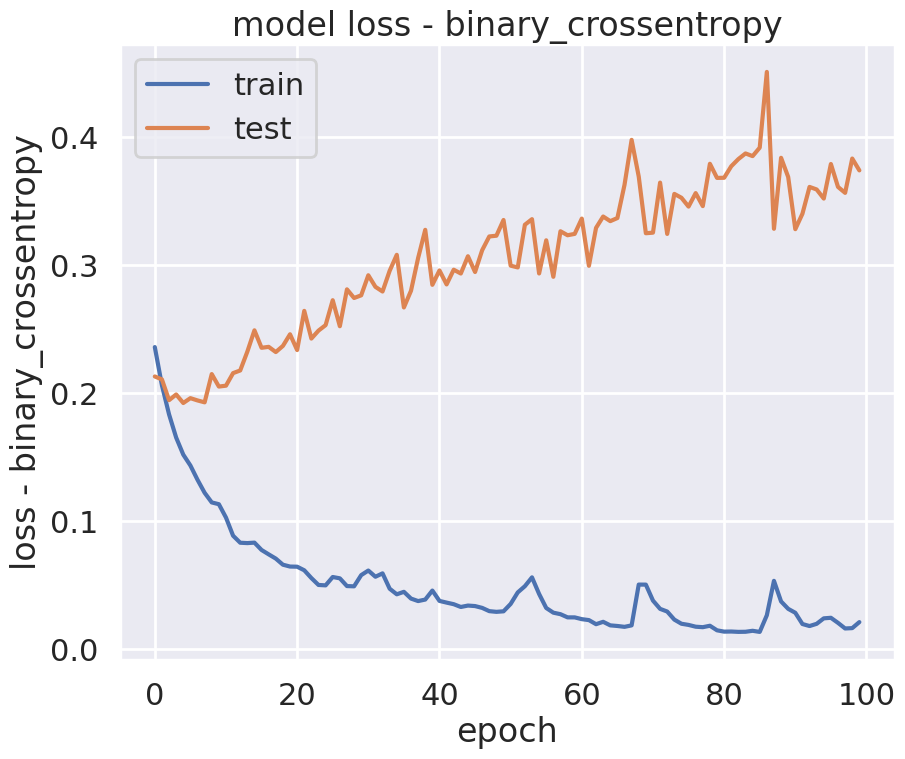

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})


sns.set_context('poster', font_scale = 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - ' + metric)
plt.ylabel('loss - ' + metric)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It's over fitting after third epoch

In [57]:
y_pred = text_classification_model.predict(dataset_test.batch(32))
y_pred[0]

19/19 [==============================] - 5s 258ms/step


array([8.5477013e-04, 8.6138207e-05, 3.8618728e-04, 1.4972786e-04,
       2.0624720e-05, 2.8590335e-07, 4.9633027e-06, 1.5423493e-05,
       9.1524996e-08, 2.0431221e-06, 1.5814329e-06, 6.7834219e-07],
      dtype=float32)

In [29]:
class TextClassificationModel(keras.Model):
  def __init__(self, encoder):
    super(TextClassificationModel, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = True
    self.dropout1 = layers.Dropout(0.1)
    self.dropout2 = layers.Dropout(0.1)
    self.dropout3 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(100, activation="relu")
    self.dense2 = layers.Dense(50, activation="relu")
    self.dense3 = layers.Dense(12, activation="sigmoid")

  def call(self, input):
    x = self.encoder(input)
    x = x.logits
    x = self.dropout1(x)
    x = self.dense1(x)
    #x = self.dropout2(x)
    x = self.dense2(x)
    #x = self.dropout3(x)
    x = self.dense3(x)
    return x

In [30]:
text_classification_model = TextClassificationModel(model_bert)

metric = "binary_crossentropy"

text_classification_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.BinaryCrossentropy(
    name="binary_crossentropy", dtype=None, from_logits=False, label_smoothing=0))

Let's Try 5 epoch

In [31]:
history = text_classification_model.fit(
    dataset_train.shuffle(1000).batch(32),
    epochs=5,
    validation_data=dataset_test.batch(32)
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 159s 1s/step - loss: 0.3897 - binary_crossentropy: 0.3897 - val_loss: 0.3011 - val_binary_crossentropy: 0.3011
Epoch 2/5
63/63 [==============================] - 89s 1s/step - loss: 0.2889 - binary_crossentropy: 0.2889 - val_loss: 0.2477 - val_binary_crossentropy: 0.2477
Epoch 3/5
63/63 [==============================] - 90s 1s/step - loss: 0.2510 - binary_crossentropy: 0.2510 - val_loss: 0.2289 - val_binary_crossentropy: 0.2289
Epoch 4/5
63/63 [==============================] - 86s 1s/step - loss: 0.2252 - binary_crossentropy: 0.2252 - val_loss: 0.2228 - val_binary_crossentropy: 0.2228
Epoch 5/5
63/63 [==============================] - 90s 1s/step - loss: 0.2000 - binary_crossentropy: 0.2000 - val_loss: 0.2065 - val_binary_crossentropy: 0.2065


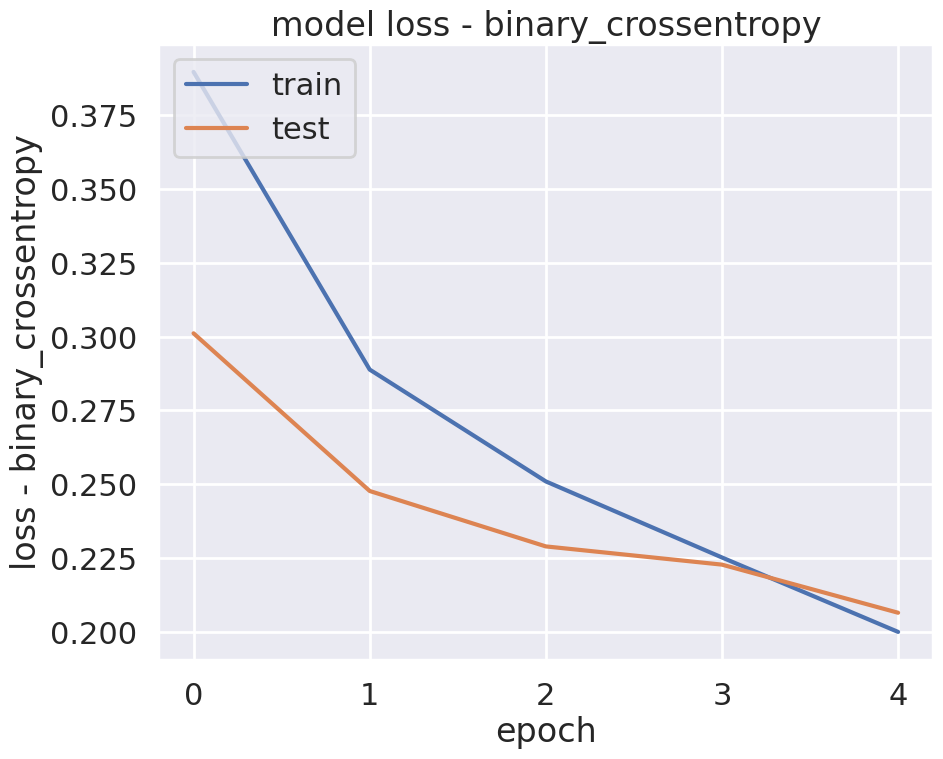

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})


sns.set_context('poster', font_scale = 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - ' + metric)
plt.ylabel('loss - ' + metric)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

let's take the model

In [33]:
text_classification_model.save("model_threath")

In [34]:
!zip -r model_threath.zip model_threath

  adding: model_threath/ (stored 0%)
  adding: model_threath/assets/ (stored 0%)
  adding: model_threath/keras_metadata.pb (deflated 95%)
  adding: model_threath/saved_model.pb (deflated 92%)
  adding: model_threath/fingerprint.pb (stored 0%)
  adding: model_threath/variables/ (stored 0%)
  adding: model_threath/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: model_threath/variables/variables.index (deflated 79%)


In [35]:
from google.colab import files
files.download('model_threath.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
y_pred = text_classification_model.predict(dataset_test.batch(32))
y_pred[0]

19/19 [==============================] - 11s 256ms/step


array([0.08372393, 0.11707484, 0.1256576 , 0.03696692, 0.01780065,
       0.00338794, 0.00578241, 0.09904733, 0.00125809, 0.00874065,
       0.00209631, 0.01160388], dtype=float32)

In [38]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = (y_pred >0.50)


print(classification_report(Y_test, y_pred))

roc_auc = roc_auc_score(Y_test, y_pred, average = 'macro')
print(roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       232
           1       0.67      0.50      0.57       167
           2       0.70      0.39      0.50        89
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        14
           7       0.55      0.73      0.63       154
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         5

   micro avg       0.69      0.51      0.59       758
   macro avg       0.23      0.19      0.20       758
weighted avg       0.61      0.51      0.54       758
 samples avg       0.37      0.32      0.32       758

0.5789814556265589


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


because our data imbalance, it efect to our prediction

Try 5 more epoch

In [39]:
history2 = text_classification_model.fit(
    dataset_train.shuffle(1000).batch(32),
    epochs=5,
    validation_data=dataset_test.batch(32)
)

Epoch 1/5
63/63 [==============================] - 82s 1s/step - loss: 0.1778 - binary_crossentropy: 0.1778 - val_loss: 0.2024 - val_binary_crossentropy: 0.2024
Epoch 2/5
63/63 [==============================] - 85s 1s/step - loss: 0.1614 - binary_crossentropy: 0.1614 - val_loss: 0.1850 - val_binary_crossentropy: 0.1850
Epoch 3/5
63/63 [==============================] - 84s 1s/step - loss: 0.1435 - binary_crossentropy: 0.1435 - val_loss: 0.1845 - val_binary_crossentropy: 0.1845
Epoch 4/5
63/63 [==============================] - 84s 1s/step - loss: 0.1298 - binary_crossentropy: 0.1298 - val_loss: 0.1974 - val_binary_crossentropy: 0.1974
Epoch 5/5
63/63 [==============================] - 86s 1s/step - loss: 0.1227 - binary_crossentropy: 0.1227 - val_loss: 0.1992 - val_binary_crossentropy: 0.1992


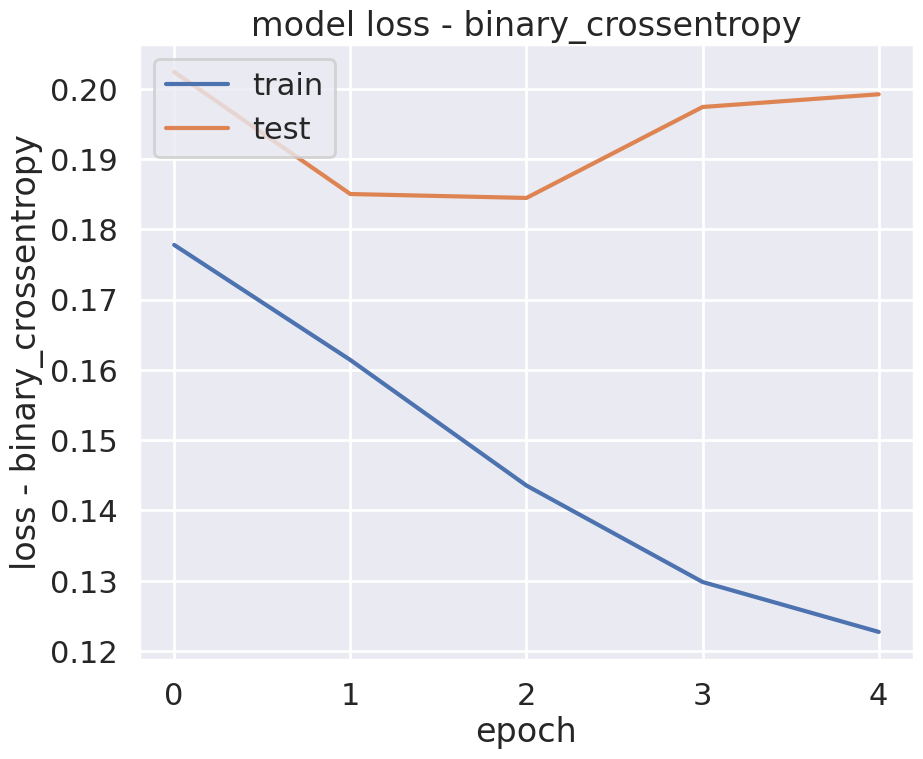

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})


sns.set_context('poster', font_scale = 1)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss - ' + metric)
plt.ylabel('loss - ' + metric)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model yang bagus untuk saat ini merupakan model sebelumnya

In [41]:
# Load the saved model
loaded_model = tf.keras.models.load_model("model_threath")

In [ ]:
loaded_model.fit(dataset_train.shuffle(1000).batch(32),
    epochs=1,
    validation_data=dataset_test.batch(32)
)

In [46]:
text_classification_model.predict(dataset_test.batch(32))

19/19 [==============================] - 5s 264ms/step


array([[2.1966772e-02, 2.0018984e-02, 2.4599029e-02, ..., 2.9738914e-04,
        2.7024807e-05, 1.2151205e-03],
       [1.5344247e-02, 1.9553088e-01, 3.3379190e-02, ..., 2.4945661e-03,
        3.3396069e-04, 1.5754469e-03],
       [3.6547381e-02, 2.0606857e-02, 2.0574046e-02, ..., 3.2823137e-04,
        2.4883846e-05, 1.0740075e-03],
       ...,
       [8.9295572e-01, 1.7435114e-01, 3.8841563e-01, ..., 4.3159422e-02,
        2.4072992e-02, 1.5814116e-02],
       [3.6325295e-02, 2.0802531e-02, 2.0268477e-02, ..., 3.2337356e-04,
        2.4597932e-05, 9.8640856e-04],
       [7.5724810e-01, 4.0777799e-02, 1.3069695e-02, ..., 1.7677633e-03,
        1.4806305e-04, 1.0663402e-03]], dtype=float32)

In [ ]:
text_classification_model.save("model_threath.h5")

In [1]:
!unzip model_bert_threath.zip

Archive:  model_bert_threath.zip
   creating: model_bert/
  inflating: model_bert/tf_model.h5  
  inflating: model_bert/config.json  
